In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import geopandas as gpd
import omnivida_loader as ov
import statsmodels.api         as sm
import statsmodels.formula.api as smf
%matplotlib inline

### Let's start by loading the cleansed datasets into pandas DataFrames. 

In [2]:
adherence, adherence_change = ov.get_adherence_dataset()
basic_info = ov.get_basic_info_dataset()

### Basic personal data

In [3]:
basic_info.head()

,id_patient,age,gender,education,civil_status,department,city,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate
0,500547,58.0,M,SECUNDARIA,CASADO (A),ANTIOQUIA,MEDELLIN,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19
1,500588,15.0,M,PRIMARIA,SOLTERO (A),SANTAFE DE BOGOTA D.C,BOGOTA,2.0,URBANA,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2004-12-19
2,502989,29.0,M,UNIVERSITARIO,SOLTERO (A),ANTIOQUIA,MEDELLIN,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22
3,506808,11.0,M,EDAD PREESCOLAR,SOLTERO (A),ANTIOQUIA,BELLO,1.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2008-10-06
4,512938,22.0,F,SECUNDARIA,SOLTERO (A),ANTIOQUIA,MEDELLIN,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1997-10-15


In [4]:
list(basic_info.socioeconomic_level.unique())

['A',
 'B',
 'NIVEL 0 DEL SISBEN',
 'NIVEL 1 DEL SISBEN',
 'C',
 nan,
 'NIVEL 2 DEL SISBEN']

In [5]:
basic_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id_patient                        872 non-null    int64         
 1   age                               872 non-null    float64       
 2   gender                            870 non-null    category      
 3   education                         862 non-null    category      
 4   civil_status                      872 non-null    category      
 5   department                        872 non-null    object        
 6   city                              872 non-null    object        
 7   social_stratum                    872 non-null    float64       
 8   zone                              872 non-null    category      
 9   socioeconomic_level               860 non-null    category      
 10  occupation                        872 non-null    

In [6]:
basic_info.describe(include='all')

,id_patient,age,gender,education,civil_status,department,city,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate
count,8.720000e+02,872.000000,870,862,872,872,872,872.000000,872,860,872,850,850,852,872
unique,NaN,NaN,2,8,6,11,52,NaN,2,6,8,4,3,5,858
top,NaN,NaN,F,SECUNDARIA,SOLTERO (A),ANTIOQUIA,MEDELLIN,NaN,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1984-05-28 00:00:00
freq,NaN,NaN,604,384,410,699,464,NaN,839,629,457,826,532,471,2
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1932-04-05 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-04 00:00:00
mean,1.259526e+06,41.146789,NaN,NaN,NaN,NaN,NaN,2.983945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.343817e+05,18.222354,NaN,NaN,NaN,NaN,NaN,0.865047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.005470e+05,5.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.887368e+05,27.000000,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's define a new variable called `grupo_edad` (age group), to process age as a categorial variable:

In [7]:
basic_info['age_group'] = basic_info['age'].apply(lambda x: np.ceil(x/10.))

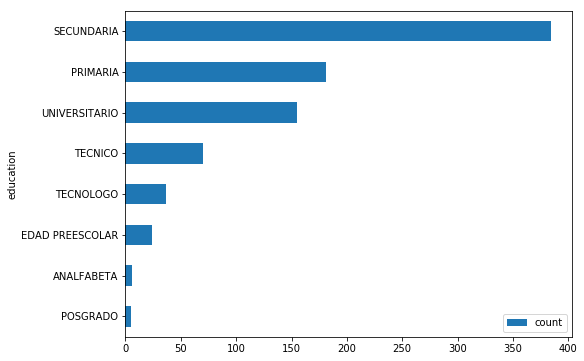

In [8]:
escolaridad = basic_info[['id_patient', 'education']].groupby('education').size().sort_values(ascending=False).reset_index(name='count')
escolaridad.sort_values(by='count', ascending=True).plot(kind='barh', x='education', figsize=(8,6))

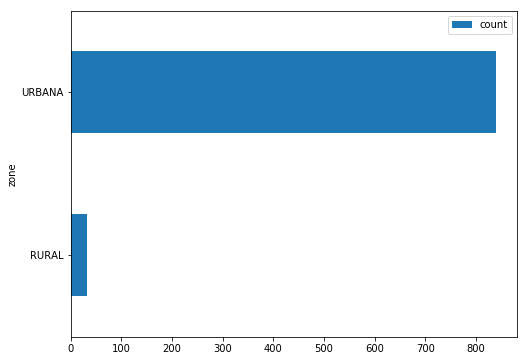

In [9]:
zona = basic_info[['id_patient', 'zone']].groupby('zone').size().sort_values(ascending=False).reset_index(name='count')
zona.sort_values(by='count', ascending=True).plot(kind='barh', x='zone', figsize=(8,6))

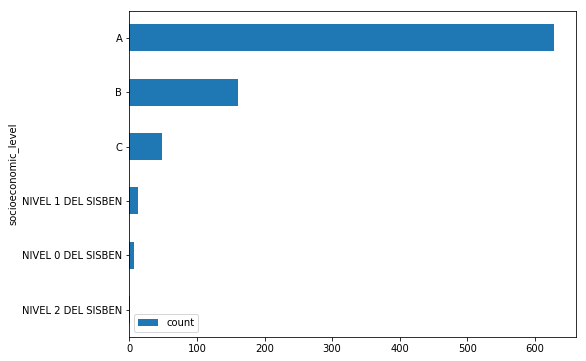

In [10]:
nivel_socioeconomico = basic_info[['id_patient', 'socioeconomic_level']].groupby('socioeconomic_level').size().sort_values(ascending=False).reset_index(name='count')
nivel_socioeconomico.sort_values(by='count', ascending=True).plot(kind='barh', x='socioeconomic_level', figsize=(8,6))

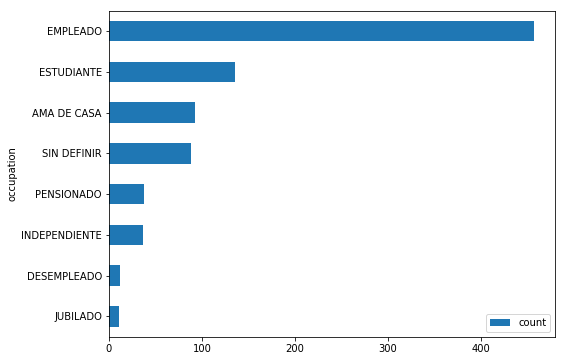

In [11]:
ocupacion = basic_info[['id_patient', 'occupation']].groupby('occupation').size().sort_values(ascending=False).reset_index(name='count')
ocupacion.sort_values(by='count', ascending=True).plot(kind='barh', x='occupation', figsize=(8,6))

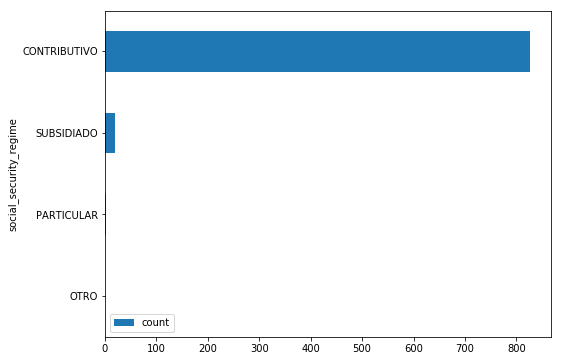

In [12]:
regimen = basic_info[['id_patient', 'social_security_regime']].groupby('social_security_regime').size().sort_values(ascending=False).reset_index(name='count')
regimen.sort_values(by='count', ascending=True).plot(kind='barh', x='social_security_regime', figsize=(8,6))

In [13]:
adherence.head()

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
0,500547,2016-07-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
1,500547,2019-03-14,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
2,500547,2019-10-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
3,500547,2019-12-09,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
4,500547,2020-01-16,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A


In [14]:
adherence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4765 entries, 0 to 4764
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_patient           4765 non-null   int64         
 1   survey_date          4765 non-null   datetime64[ns]
 2   morisky_green        4765 non-null   float64       
 3   smaq1                4765 non-null   float64       
 4   smaq2                4765 non-null   float64       
 5   espa                 4765 non-null   float64       
 6   nm_espa              4765 non-null   float64       
 7   qualitative_result   4765 non-null   float64       
 8   quantitative_result  4765 non-null   float64       
 9   category             4765 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(7), int64(1)
memory usage: 340.0 KB


In [15]:
adherence.describe(include='all')

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
count,4.765000e+03,4765,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765
unique,NaN,1433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,2019-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,NaN,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2319
first,NaN,2012-04-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-05-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.238039e+06,NaN,0.849528,0.836726,3.774816,0.830220,5.603148,0.793494,3.774816,NaN
std,4.295039e+05,NaN,0.357571,0.369654,0.798742,0.375478,0.912014,0.404840,0.798742,NaN
min,5.005470e+05,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,8.716330e+05,NaN,1.000000,1.000000,4.000000,1.000000,5.000000,1.000000,4.000000,NaN


,id_patient,count_records
0,1769865,41
1,979605,30
2,1132214,28
3,1676414,26
4,622031,26
5,1196034,25
6,916510,24
7,1828862,23
8,1536265,23
9,1399081,23


4765


Text(0.5,1,'Number of adherence records per patient')

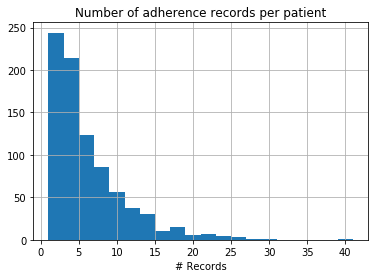

In [16]:
num_records_per_patient = adherence.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_patient.head(10))
print(sum(num_records_per_patient['count_records']))
num_records_per_patient.hist('count_records', bins=20)
plt.xlabel('# Records')
plt.title('Number of adherence records per patient')

,category,count_records
0,A,2319
1,M,1251
2,A-,689
3,N+,496
4,N,10


4765


Text(0.5,1,'Number records per category')

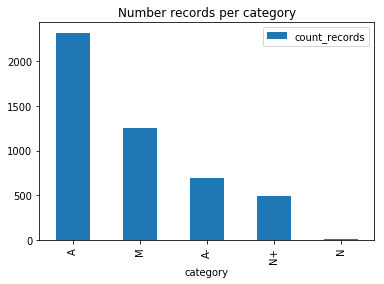

In [17]:
num_records_per_category = adherence.groupby('category').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_category)
print(sum(num_records_per_category['count_records']))
num_records_per_category.plot(kind='bar', x='category')
# plt.xlabel('# Records')
plt.title('Number records per category')

In [18]:
adherence_pivot = adherence.copy()
adherence_pivot['survey_month'] = adherence_pivot['survey_date'].dt.month
adherence_pivot['survey_year'] = adherence_pivot['survey_date'].dt.year
adherence_pivot_cuantitativo = pd.pivot_table(adherence_pivot, values='quantitative_result', index='survey_month', columns='survey_year', aggfunc='mean')
adherence_pivot_cualitativo = pd.pivot_table(adherence_pivot, values='qualitative_result', index='survey_month', columns='survey_year', aggfunc='sum')
adherence_pivot_enrevistas = pd.pivot_table(adherence_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

Text(0.5,1,'Reportes de adherencia')

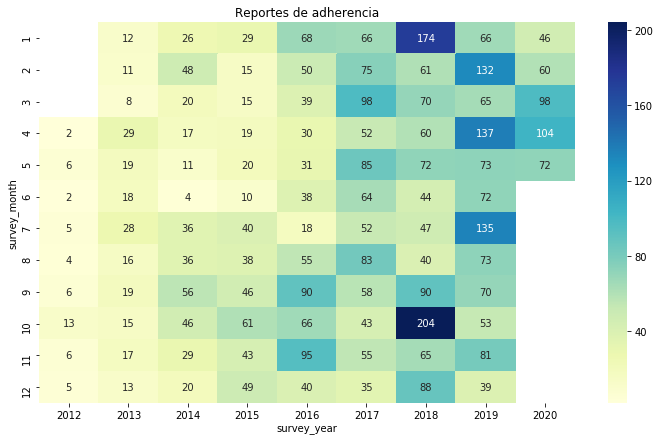

In [19]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_enrevistas, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Reportes de adherencia')

Text(0.5,1,'Number of adherent patients per month')

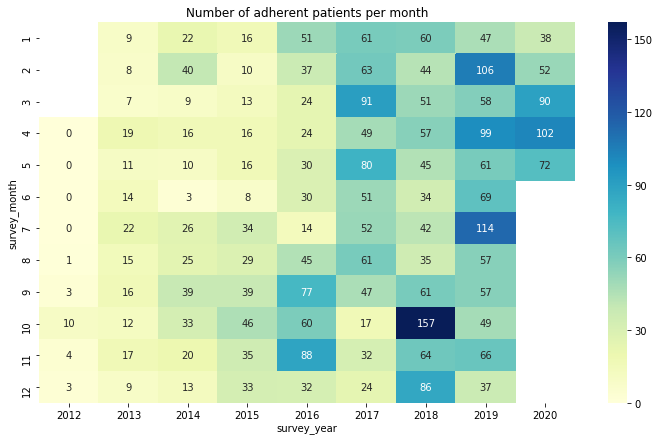

In [20]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_cualitativo, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Number of adherent patients per month')

Text(0.5,1,'Percentage of adherent patients per month')

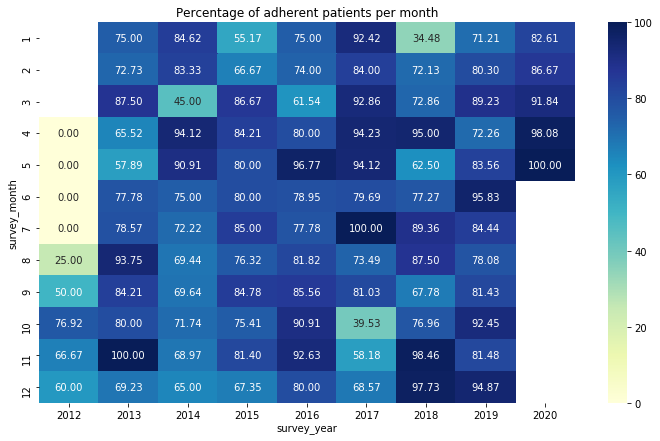

In [21]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(100*(adherence_pivot_cualitativo/adherence_pivot_enrevistas), ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Percentage of adherent patients per month')

Text(0.5,1,'Average adherence score per month')

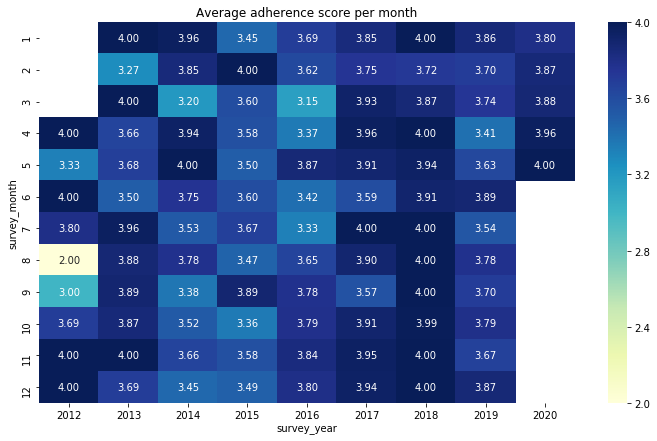

In [22]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_cuantitativo, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Average adherence score per month')

Text(0.5,1,'Median adherence (qualitative) score per month')

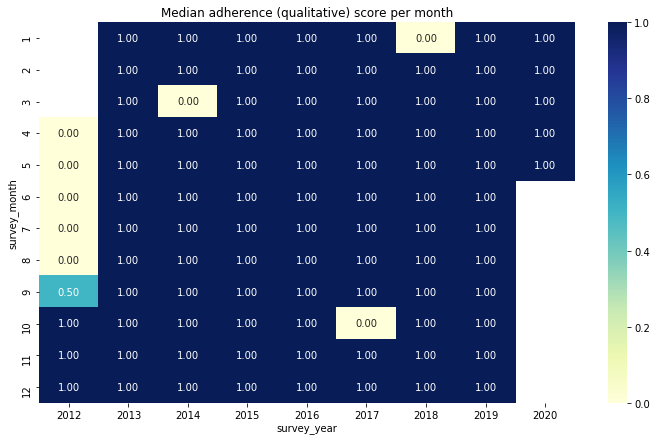

In [23]:
adherence_pivot_cualitativo2 = pd.pivot_table(adherence_pivot, values='qualitative_result', index='survey_month', columns='survey_year', aggfunc='median')
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_cualitativo2, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Median adherence (qualitative) score per month')

In [24]:
adherence_change.head(10)

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category,morisky_change,smaq1_change,smaq2_change,espa_change,nm_espa_change,qualitative_result_change,quantitative_result_change,days_since_last_control,num_reports,ongoing_adherence_percentage
0,500547,2016-07-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
1,500547,2019-03-14,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,976.0,2,100.0
2,500547,2019-10-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.0,3,100.0
3,500547,2019-12-09,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,4,100.0
4,500547,2020-01-16,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,5,100.0
5,500547,2020-03-25,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,6,100.0
6,500547,2020-05-08,1.0,1.0,4.0,1.0,5.0,1.0,4.0,A,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,44.0,7,100.0
7,500588,2019-04-26,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
8,502989,2014-08-22,0.0,0.0,2.0,1.0,5.0,0.0,2.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
9,502989,2014-10-28,0.0,0.0,2.0,0.0,5.0,0.0,2.0,M,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,67.0,2,0.0


In [25]:
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'quantitative_result', 'qualitative_result_change', 'quantitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage', 'num_reports']
adherence_change_analysis = adherence_change[select_fields]
adherence_change_analysis.head(30)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports
0,500547,2016-07-11,A,1.0,4.0,NaN,NaN,NaN,100.000000,1
1,500547,2019-03-14,A,1.0,4.0,0.0,0.0,976.0,100.000000,2
2,500547,2019-10-11,A,1.0,4.0,0.0,0.0,211.0,100.000000,3
3,500547,2019-12-09,A,1.0,4.0,0.0,0.0,59.0,100.000000,4
4,500547,2020-01-16,A,1.0,4.0,0.0,0.0,38.0,100.000000,5
5,500547,2020-03-25,A,1.0,4.0,0.0,0.0,69.0,100.000000,6
6,500547,2020-05-08,A,1.0,4.0,0.0,0.0,44.0,100.000000,7
7,500588,2019-04-26,A,1.0,4.0,NaN,NaN,NaN,100.000000,1
8,502989,2014-08-22,M,0.0,2.0,NaN,NaN,NaN,0.000000,1
9,502989,2014-10-28,M,0.0,2.0,0.0,0.0,67.0,0.000000,2


In [26]:
adherence_change_analysis_pivot = adherence_change_analysis.copy()
adherence_change_analysis_pivot['survey_month'] = adherence_change_analysis_pivot['survey_date'].dt.month
adherence_change_analysis_pivot['survey_year'] = adherence_change_analysis_pivot['survey_date'].dt.year
adherence_pivot_dias_control = pd.pivot_table(adherence_change_analysis_pivot, values='days_since_last_control', index='survey_month', columns='survey_year', aggfunc='mean')
adherence_pivot_adher_percentage = pd.pivot_table(adherence_change_analysis_pivot, values='ongoing_adherence_percentage', index='survey_month', columns='survey_year', aggfunc='mean')

Text(0.5,1,'Dias desde el ultimo control')

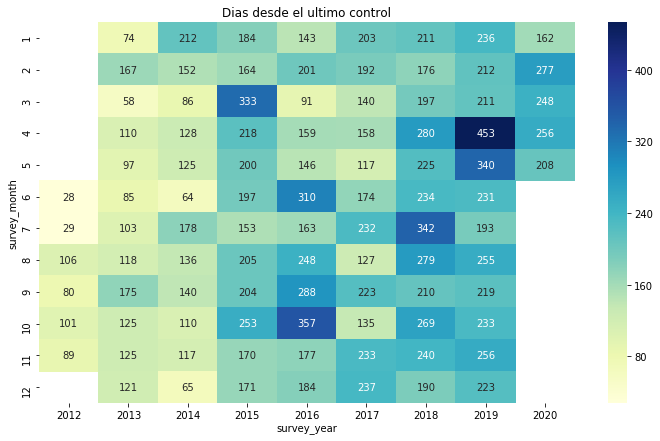

In [27]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_dias_control, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Dias desde el ultimo control')

Text(0.5,1,'Porcentage de adherencia historico promedio por mes')

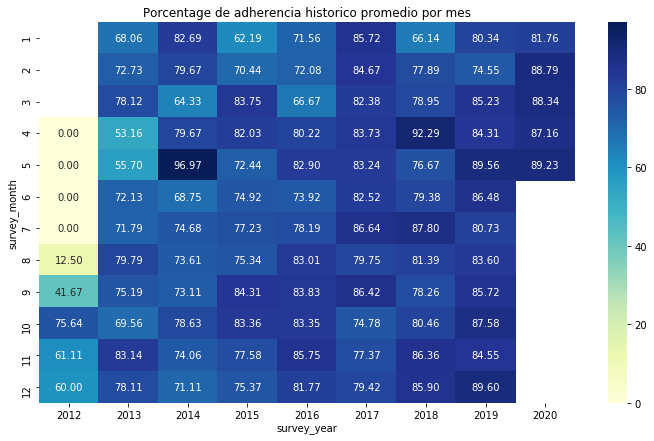

In [28]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_adher_percentage, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Porcentage de adherencia historico promedio por mes')

#### Let's have a look at those patients that went from `adherent` (i.e. 1 in the `cualitativo_ponderado` field) to `non-adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [29]:
adherence_change_analysis.head(20)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports
0,500547,2016-07-11,A,1.0,4.0,NaN,NaN,NaN,100.000000,1
1,500547,2019-03-14,A,1.0,4.0,0.0,0.0,976.0,100.000000,2
2,500547,2019-10-11,A,1.0,4.0,0.0,0.0,211.0,100.000000,3
3,500547,2019-12-09,A,1.0,4.0,0.0,0.0,59.0,100.000000,4
4,500547,2020-01-16,A,1.0,4.0,0.0,0.0,38.0,100.000000,5
5,500547,2020-03-25,A,1.0,4.0,0.0,0.0,69.0,100.000000,6
6,500547,2020-05-08,A,1.0,4.0,0.0,0.0,44.0,100.000000,7
7,500588,2019-04-26,A,1.0,4.0,NaN,NaN,NaN,100.000000,1
8,502989,2014-08-22,M,0.0,2.0,NaN,NaN,NaN,0.000000,1
9,502989,2014-10-28,M,0.0,2.0,0.0,0.0,67.0,0.000000,2


In [30]:
neg_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==-1]
neg_transition.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports
14,502989,2016-01-12,M,0.0,3.0,-1.0,-1.0,201.0,14.285714,7
16,502989,2017-01-03,M,0.0,3.0,-1.0,-1.0,354.0,22.222222,9
20,502989,2018-10-03,M,0.0,4.0,-1.0,0.0,421.0,38.461538,13
35,506808,2018-10-08,M,0.0,4.0,-1.0,0.0,131.0,85.714286,14
44,512938,2018-05-04,M,0.0,4.0,-1.0,0.0,216.0,85.714286,7
48,512938,2019-09-30,M,0.0,1.0,-1.0,-3.0,293.0,72.727273,11
51,514102,2018-01-30,A,0.0,4.0,-1.0,0.0,74.0,66.666667,3
55,524006,2015-10-13,A-,0.0,4.0,-1.0,0.0,33.0,66.666667,3
62,524006,2017-05-10,A-,0.0,3.0,-1.0,-1.0,28.0,70.000000,10
93,529410,2018-01-30,A-,0.0,4.0,-1.0,0.0,122.0,66.666667,6


In [31]:
neg_transition_count = neg_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_neg_transitions')
neg_transition_count.head(10)

,id_patient,count_neg_transitions
0,1769865,7
1,832593,7
2,622031,6
3,739693,6
4,673765,6
5,916510,6
6,1828862,5
7,1132214,5
8,747471,5
9,801004,5


Text(0.5,1,'Number of negative transitions per month')

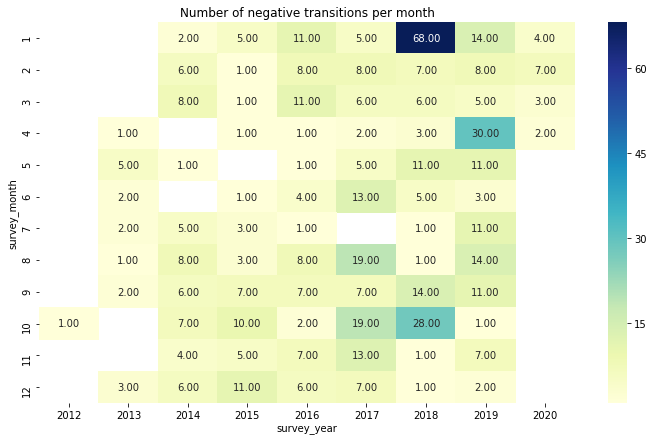

In [32]:
neg_transition_pivot = neg_transition.copy()
neg_transition_pivot['survey_month'] = neg_transition_pivot['survey_date'].dt.month
neg_transition_pivot['survey_year'] = neg_transition_pivot['survey_date'].dt.year
neg_transition_pivot = pd.pivot_table(neg_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(neg_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of negative transitions per month')

#### Let's have a look at those patients that went from `non-adherent` (i.e. 0 in the `cualitativo_ponderado` field) to `adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [33]:
pos_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==1]
pos_transition.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports
13,502989,2015-06-25,M,1.0,4.0,1.0,1.0,162.0,16.666667,6
15,502989,2016-01-15,M,1.0,4.0,1.0,1.0,3.0,25.000000,8
17,502989,2017-03-21,M,1.0,4.0,1.0,1.0,77.0,30.000000,10
21,502989,2019-02-08,M,1.0,4.0,1.0,0.0,128.0,42.857143,14
23,506808,2013-05-24,M,1.0,4.0,1.0,0.0,16.0,50.000000,2
37,506808,2019-06-14,M,1.0,4.0,1.0,4.0,113.0,81.250000,16
46,512938,2018-11-14,M,1.0,4.0,1.0,0.0,42.0,77.777778,9
52,514102,2018-09-25,A,1.0,4.0,1.0,0.0,238.0,75.000000,4
57,524006,2016-06-02,A-,1.0,4.0,1.0,0.0,206.0,60.000000,5
63,524006,2017-07-28,A-,1.0,4.0,1.0,1.0,79.0,72.727273,11


In [34]:
pos_transition_count = pos_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_pos_transitions')
pos_transition_count.head(10)

,id_patient,count_pos_transitions
0,1769865,8
1,622031,7
2,832593,7
3,1132214,6
4,673765,6
5,739693,6
6,1399081,5
7,801004,5
8,747471,5
9,916510,5


Text(0.5,1,'Number of positive transitions per month')

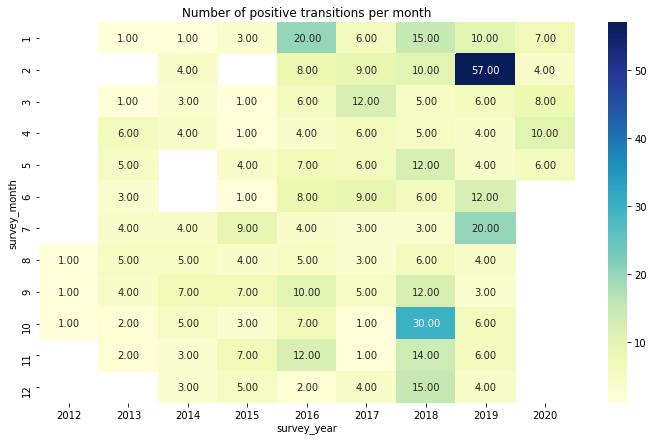

In [35]:
pos_transition_pivot = pos_transition.copy()
pos_transition_pivot['survey_month'] = pos_transition_pivot['survey_date'].dt.month
pos_transition_pivot['survey_year'] = pos_transition_pivot['survey_date'].dt.year
pos_transition_pivot = pd.pivot_table(pos_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(pos_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of positive transitions per month')

#### Let's study the influence of some demographic factors on the adherence (age, education, gender, socioeconomic status, zone, employment type)

In [36]:
basic_info_adherence = adherence_change_analysis.merge(basic_info, how='left', on='id_patient')
basic_info_adherence['category'] = basic_info_adherence['category'].astype('category')
basic_info_adherence['category'].cat.reorder_categories(['N', 'N+', 'M', 'A-', 'A'], ordered=True, inplace=True)
basic_info_adherence['age_at_survey_date'] = (np.ceil((basic_info_adherence['survey_date'] - basic_info_adherence['birthdate']) / np.timedelta64(1, 'Y'))).astype(int)

In [37]:
basic_info_adherence.head(20)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
0,500547,2016-07-11,A,1.0,4.0,NaN,NaN,NaN,100.000000,1,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,55
1,500547,2019-03-14,A,1.0,4.0,0.0,0.0,976.0,100.000000,2,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,57
2,500547,2019-10-11,A,1.0,4.0,0.0,0.0,211.0,100.000000,3,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
3,500547,2019-12-09,A,1.0,4.0,0.0,0.0,59.0,100.000000,4,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
4,500547,2020-01-16,A,1.0,4.0,0.0,0.0,38.0,100.000000,5,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
5,500547,2020-03-25,A,1.0,4.0,0.0,0.0,69.0,100.000000,6,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
6,500547,2020-05-08,A,1.0,4.0,0.0,0.0,44.0,100.000000,7,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
7,500588,2019-04-26,A,1.0,4.0,NaN,NaN,NaN,100.000000,1,...,2.0,URBANA,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2004-12-19,2.0,15
8,502989,2014-08-22,M,0.0,2.0,NaN,NaN,NaN,0.000000,1,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
9,502989,2014-10-28,M,0.0,2.0,0.0,0.0,67.0,0.000000,2,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25


1. Adherence vs. Age

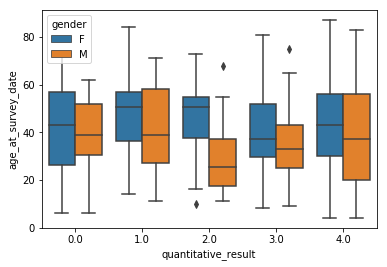

In [38]:
sns.boxplot(data=basic_info_adherence, x='quantitative_result', y='age_at_survey_date', hue='gender')

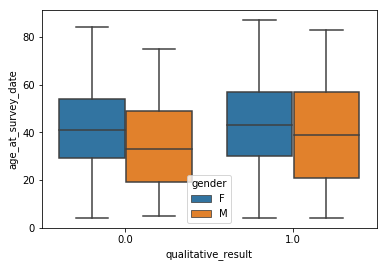

In [39]:
sns.boxplot(data=basic_info_adherence, x='qualitative_result', y='age_at_survey_date', hue='gender')

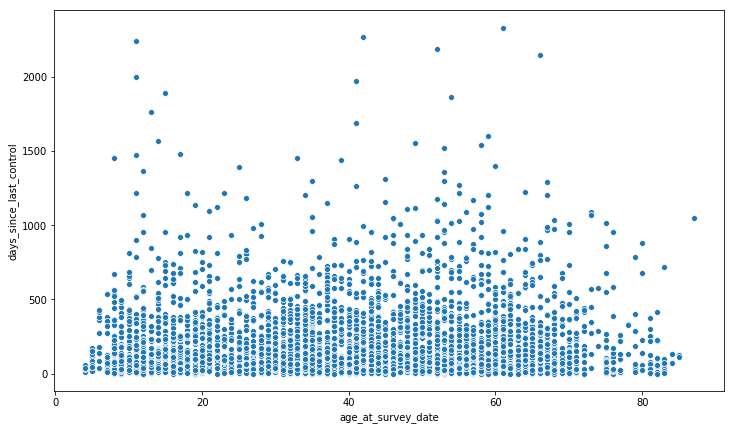

In [40]:
fig, ax = plt.subplots(figsize=(12,7))
sns.scatterplot(data=basic_info_adherence, x='age_at_survey_date', y='days_since_last_control', ax=ax)

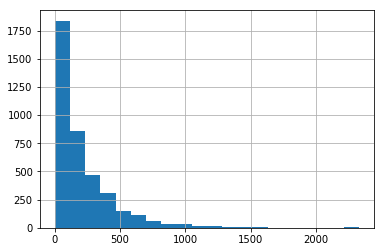

In [41]:
basic_info_adherence['days_since_last_control'].hist(bins=20)

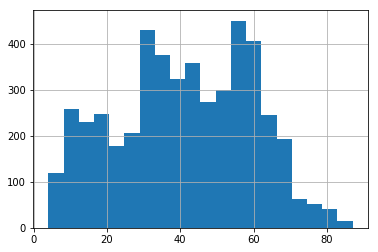

In [42]:
basic_info_adherence['age_at_survey_date'].hist(bins=20)

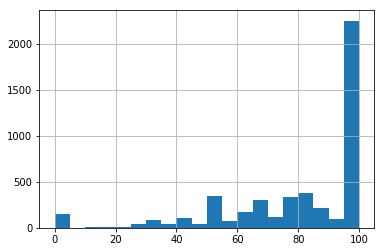

In [43]:
basic_info_adherence['ongoing_adherence_percentage'].hist(bins=20)

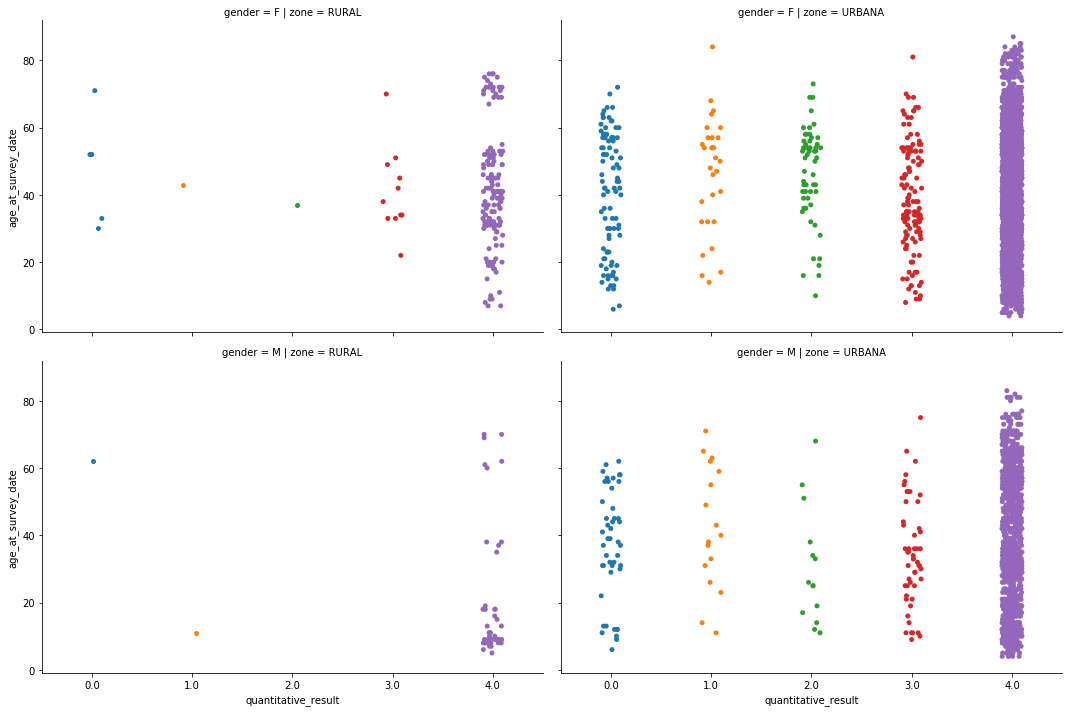

In [44]:
sns.catplot(data=basic_info_adherence, y="age_at_survey_date", x="quantitative_result", col='zone', row='gender',
            height=5, aspect=1.5)

Text(0.5,1,'Age vs Adherence category')

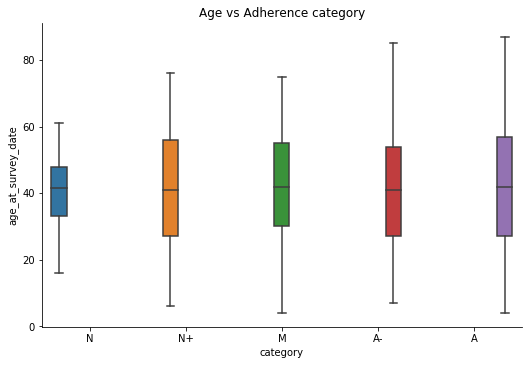

In [45]:
sns.catplot(data=basic_info_adherence, y="age_at_survey_date", x="category", hue="category",#, col='zona', row='genero',
            kind='box', height=5, aspect=1.5)
plt.title("Age vs Adherence category")

In [46]:
basic_info_adherence[['category', 'num_reports', 'days_since_last_control']].loc[basic_info_adherence['category']=='N']

,category,num_reports,days_since_last_control
1050,N,1,NaN
1771,N,1,NaN
1878,N,1,NaN
2576,N,1,NaN
3567,N,1,NaN
4099,N,1,NaN
4476,N,1,NaN
4513,N,1,NaN
4699,N,1,NaN
4700,N,2,50.0


In [47]:
basic_info_adherence[['category', 'ongoing_adherence_percentage', 'num_reports', 'days_since_last_control']].groupby('category').agg(['mean', 'std', 'count'])

ongoing_adherence_percentage                  num_reports            \
                                 mean        std count        mean       std   
category                                                                       
N                            0.000000   0.000000    10    1.100000  0.316228   
N+                          57.560546  26.573075   496    8.399194  7.693492   
M                           71.139561  26.186342  1251    6.746603  4.901483   
A-                          75.964562  20.109147   689    6.898403  5.191799   
A                           91.342011  18.490184  2319    3.769297  3.144052   

               days_since_last_control                    
         count                    mean         std count  
category                                                  
N           10               50.000000         NaN     1  
N+         496              174.232346  234.277127   439  
M         1251              191.371968  226.238613  1113  
A-         689              174.493590  182.450415   624  
A         2319              252.696224  280.514279  1748

In [48]:
basic_info_adherence[['qualitative_result', 'ongoing_adherence_percentage', 'num_reports', 'days_since_last_control']].groupby('qualitative_result').agg(['mean', 'std', 'count'])

ongoing_adherence_percentage                  num_reports  \
                                           mean        std count        mean   
qualitative_result                                                             
0.0                                   49.432860  26.171318   984    6.504065   
1.0                                   88.089234  17.508806  3781    5.213171   

                                   days_since_last_control                    
                         std count                    mean         std count  
qualitative_result                                                            
0.0                 5.286885   984              192.669704  219.758778   878  
1.0                 4.786726  3781              220.206104  256.993577  3047

In [49]:
from scipy import stats

dias_pacientes_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 1].days_since_last_control
dias_pacientes_no_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 0].days_since_last_control

statistic, pvalue = stats.ttest_ind(dias_pacientes_adherentes,dias_pacientes_no_adherentes, equal_var=False, nan_policy='omit')
statistic, pvalue

(3.1446028048042667, 0.0016931007422462173)

In [50]:
num_reportes_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 1].num_reports
num_reportes_no_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 0].num_reports

statistic, pvalue = stats.ttest_ind(num_reportes_adherentes,num_reportes_no_adherentes, equal_var=False, nan_policy='omit')
statistic, pvalue

(-6.953405349953516, 5.405853169517987e-12)

In [51]:
hist_porcentaje_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 1].ongoing_adherence_percentage
hist_porcentaje_no_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 0].ongoing_adherence_percentage

statistic, pvalue = stats.ttest_ind(hist_porcentaje_adherentes,hist_porcentaje_no_adherentes, equal_var=False, nan_policy='omit')
statistic, pvalue

(43.84980334261822, 5.0845168459662906e-253)

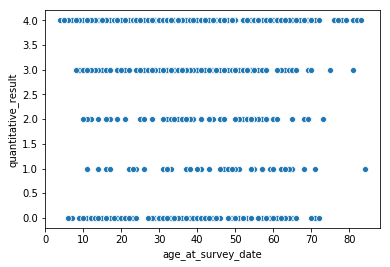

In [52]:
sns.scatterplot(x='age_at_survey_date', y='quantitative_result', data=basic_info_adherence[basic_info_adherence['qualitative_result']==0])

In [53]:
basic_info_non_adherent_patients = basic_info_adherence[(basic_info_adherence['quantitative_result'] < 4) & (basic_info_adherence['qualitative_result']==0)]
basic_info_non_adherent_patients

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
8,502989,2014-08-22,M,0.0,2.0,NaN,NaN,NaN,0.000000,1,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
9,502989,2014-10-28,M,0.0,2.0,0.0,0.0,67.0,0.000000,2,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
11,502989,2015-01-07,M,0.0,3.0,0.0,-1.0,47.0,0.000000,4,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
12,502989,2015-01-14,M,0.0,3.0,0.0,0.0,7.0,0.000000,5,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
14,502989,2016-01-12,M,0.0,3.0,-1.0,-1.0,201.0,14.285714,7,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,1995390,2015-11-27,M,0.0,0.0,-1.0,-4.0,224.0,75.000000,4,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1964-10-22,6.0,52
4739,1997065,2016-06-09,M,0.0,0.0,-1.0,-4.0,139.0,77.777778,9,...,3.0,URBANA,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2011-03-20,1.0,6
4746,1997825,2019-08-01,M,0.0,3.0,-1.0,-1.0,393.0,50.000000,2,...,3.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1991-12-27,3.0,28
4752,1998401,2014-03-05,A-,0.0,3.0,-1.0,-1.0,21.0,80.000000,5,...,2.0,URBANA,A,AMA DE CASA,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1970-01-11,5.0,45


In [54]:
basic_info_adherent_patients = basic_info_adherence[(basic_info_adherence['quantitative_result'] == 4) & (basic_info_adherence['qualitative_result']==1)]
basic_info_adherent_patients

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
0,500547,2016-07-11,A,1.0,4.0,NaN,NaN,NaN,100.0,1,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,55
1,500547,2019-03-14,A,1.0,4.0,0.0,0.0,976.0,100.0,2,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,57
2,500547,2019-10-11,A,1.0,4.0,0.0,0.0,211.0,100.0,3,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
3,500547,2019-12-09,A,1.0,4.0,0.0,0.0,59.0,100.0,4,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
4,500547,2020-01-16,A,1.0,4.0,0.0,0.0,38.0,100.0,5,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,1999536,2018-08-08,A,1.0,4.0,NaN,NaN,NaN,100.0,1,...,4.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1991-09-10,3.0,27
4761,1999536,2020-02-22,A,1.0,4.0,0.0,0.0,563.0,100.0,2,...,4.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1991-09-10,3.0,29
4762,1999629,2018-04-06,A,1.0,4.0,NaN,NaN,NaN,100.0,1,...,3.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,COTIZANTE,SIN EMPLEO,1998-11-14,3.0,20
4763,1999629,2018-05-04,A,1.0,4.0,0.0,0.0,28.0,100.0,2,...,3.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,COTIZANTE,SIN EMPLEO,1998-11-14,3.0,20


In [55]:
adherence[adherence['id_patient']==1012279]

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
1663,1012279,2018-07-27,1.0,1.0,4.0,1.0,6.0,1.0,4.0,M
1664,1012279,2019-06-11,0.0,0.0,3.0,1.0,5.0,0.0,3.0,M
1665,1012279,2019-07-16,1.0,1.0,4.0,1.0,6.0,1.0,4.0,M
1666,1012279,2020-02-22,1.0,1.0,4.0,0.0,5.0,0.0,4.0,M


In [56]:
corr_basic_info_adherence = basic_info_adherence.loc[:, ~basic_info_adherence.columns.isin(['id_patient', 'age', 'age_group'])].corr()

Text(0.5,1,'Correlation Matrix')

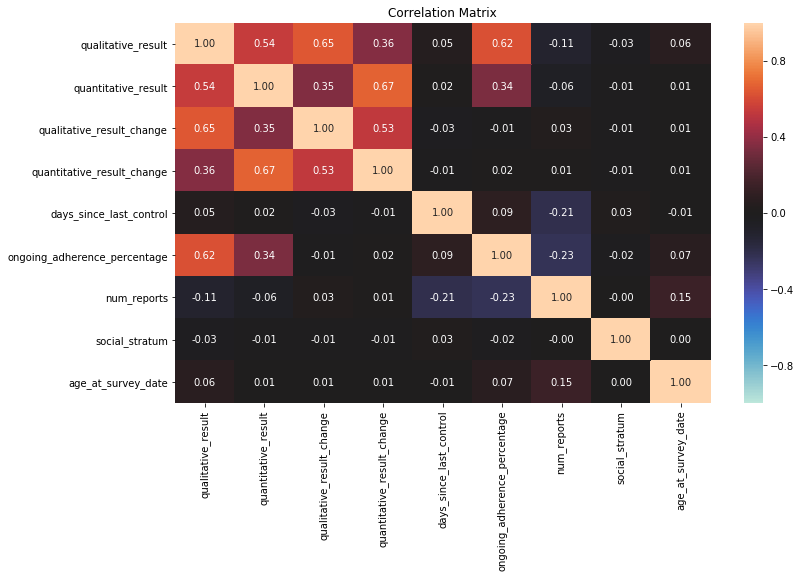

In [58]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_basic_info_adherence, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [59]:
corr_basic_info_non_adherent = basic_info_non_adherent_patients.loc[:, ~basic_info_non_adherent_patients.columns.isin(['id_patient', 'age', 'age_group'])].corr()

Text(0.5,1,'Correlation Matrix')

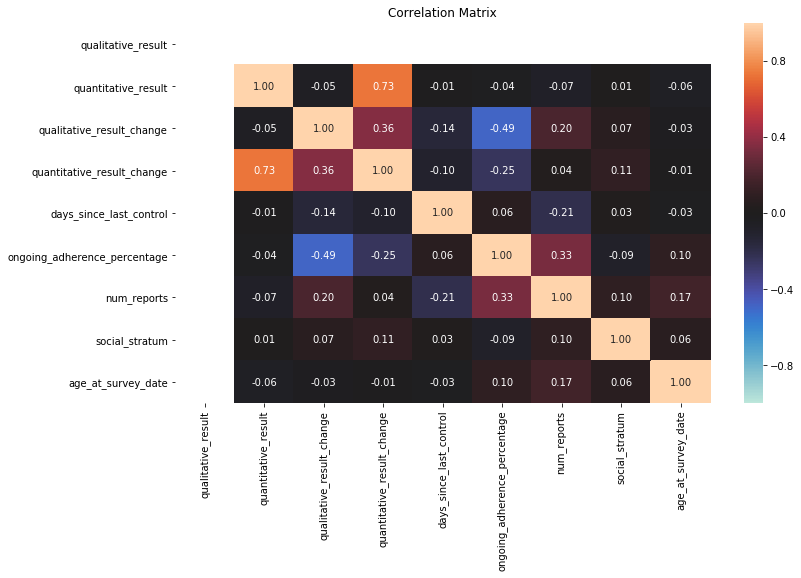

In [61]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_basic_info_non_adherent, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [62]:
corr_basic_info_adherent_patients = basic_info_adherent_patients.loc[:, ~basic_info_adherent_patients.columns.isin(['id_patient', 'age', 'age_group'])].corr()

Text(0.5,1,'Correlation Matrix')

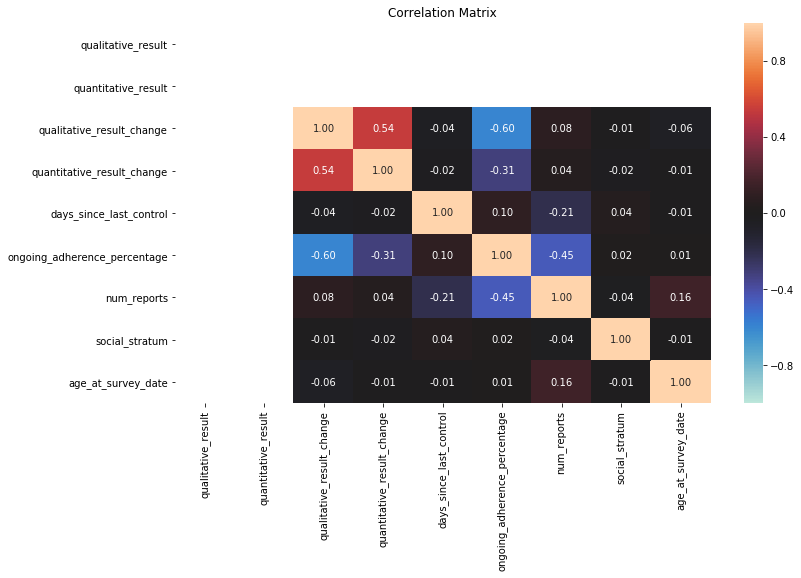

In [63]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_basic_info_adherent_patients, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

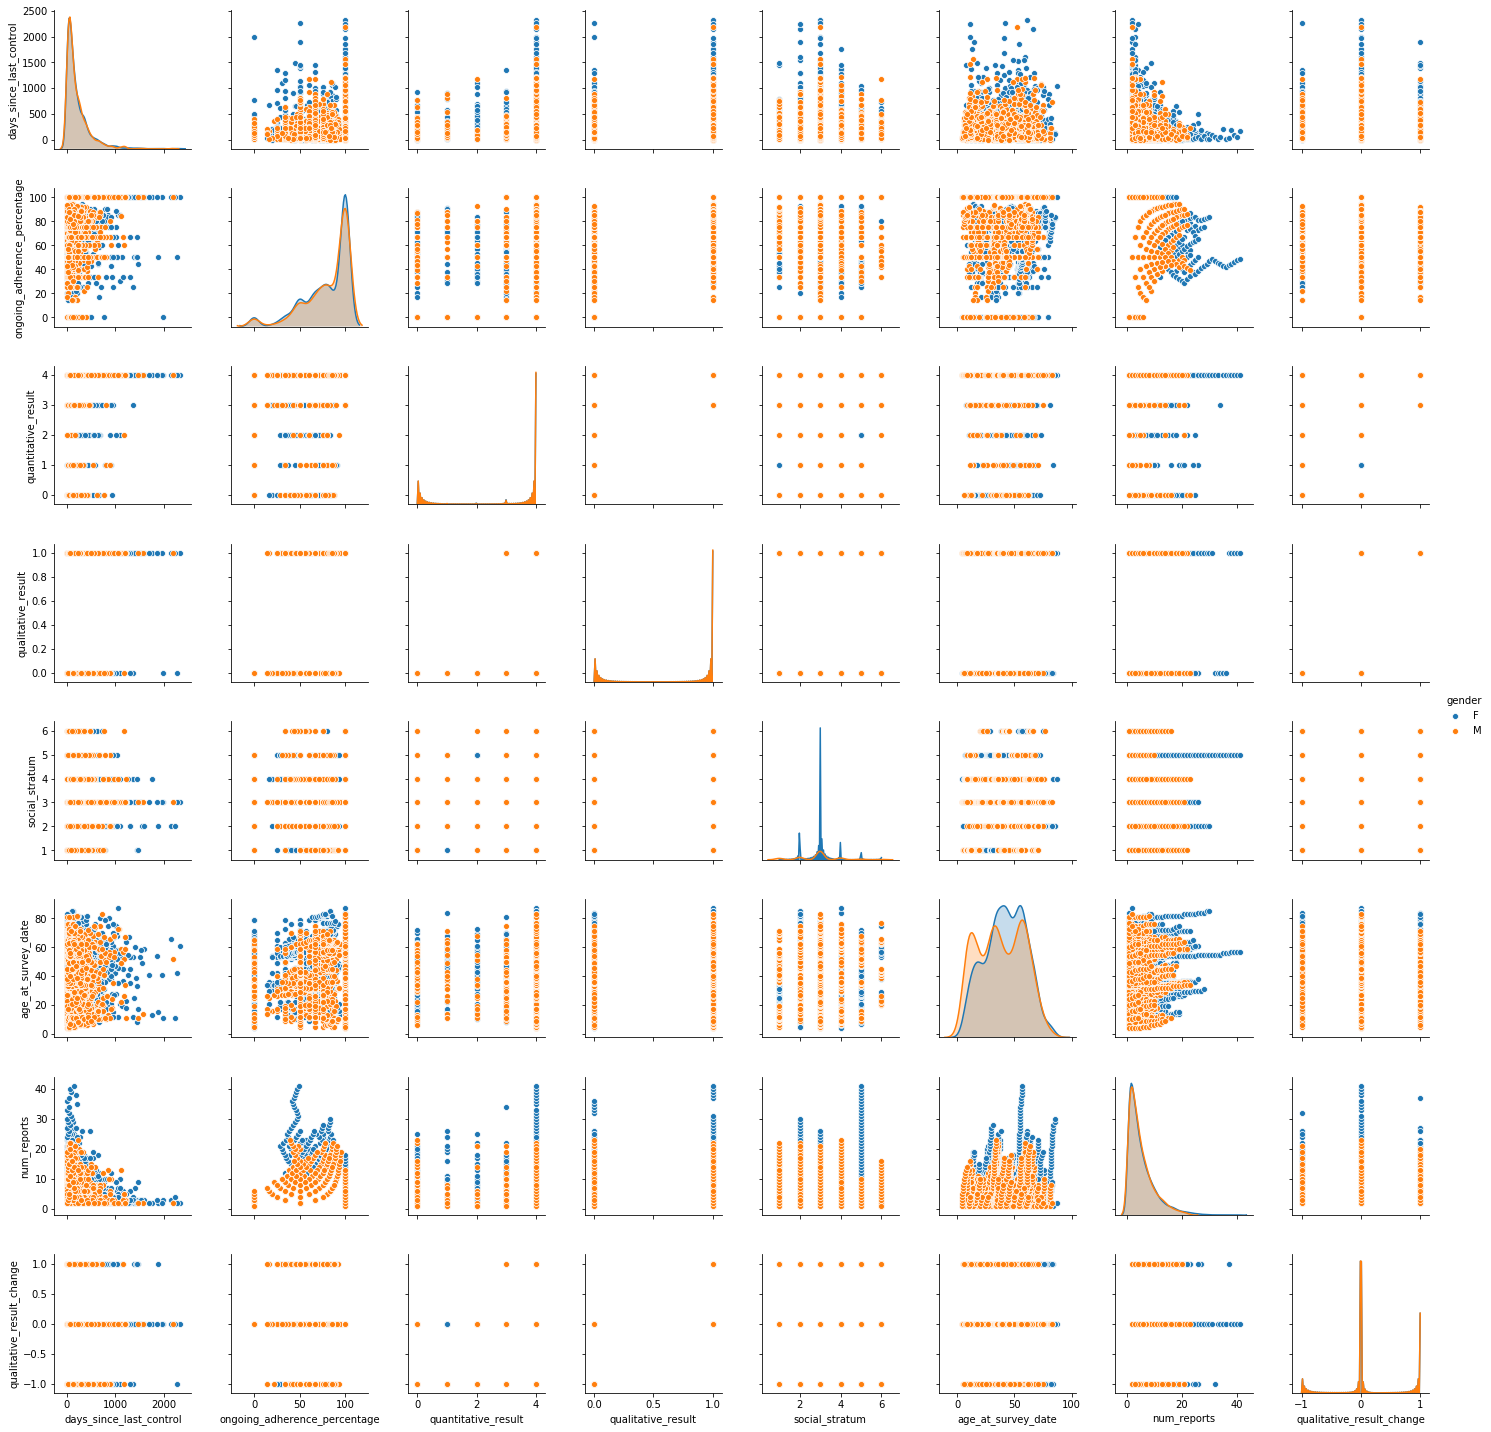

In [64]:
select_vars=['days_since_last_control', 'ongoing_adherence_percentage', 'quantitative_result', 'qualitative_result', 'social_stratum', 'age_at_survey_date', 'num_reports', 'qualitative_result_change']
sns.pairplot(basic_info_adherence, vars=select_vars, hue='gender', dropna=True)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


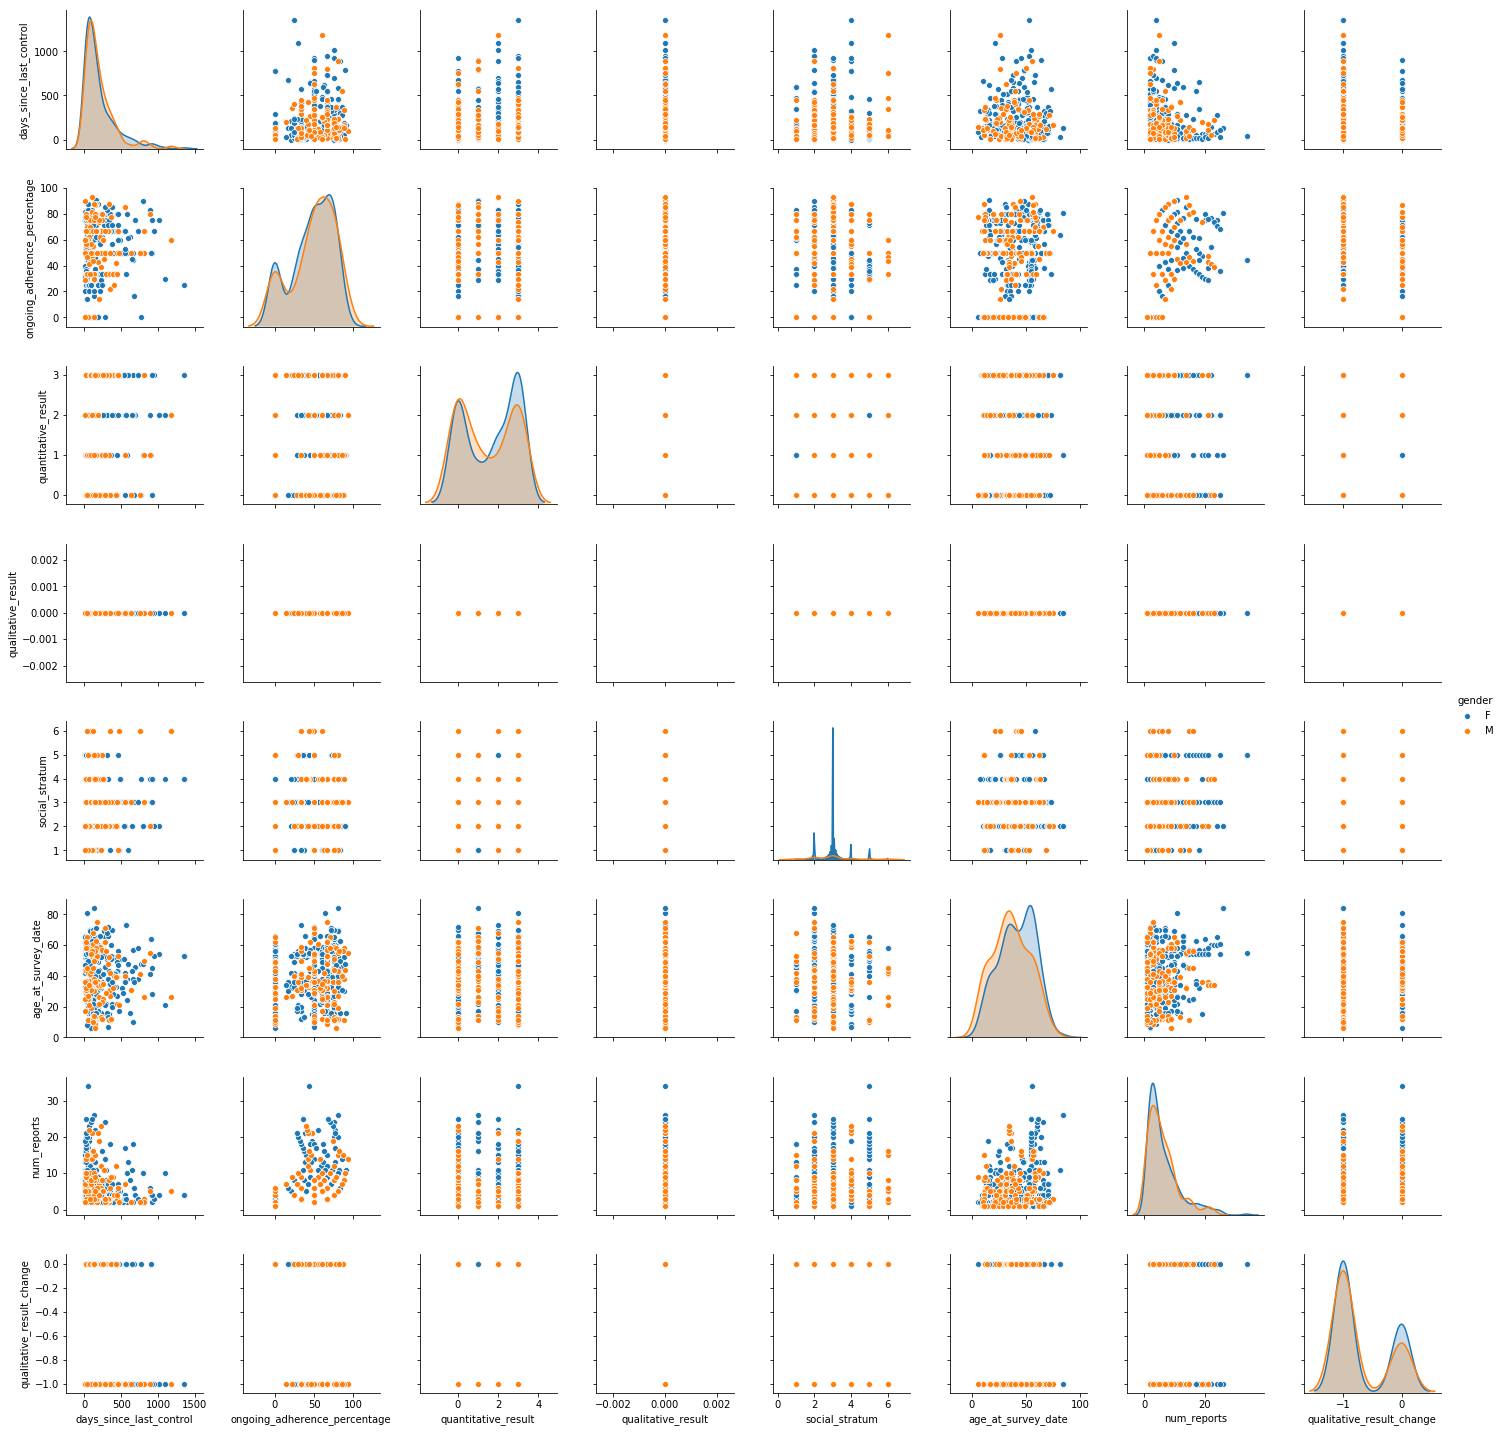

In [65]:
select_vars=['days_since_last_control', 'ongoing_adherence_percentage', 'quantitative_result', 'qualitative_result', 'social_stratum', 'age_at_survey_date', 'num_reports', 'qualitative_result_change']
sns.pairplot(basic_info_non_adherent_patients, vars=select_vars, hue='gender', dropna=True)

In [66]:
print(basic_info_adherent_patients.shape)
print(basic_info_non_adherent_patients.shape)


(3761, 26)
(440, 26)


In [67]:
balanced_sample = pd.concat([basic_info_adherent_patients.sample(basic_info_non_adherent_patients.shape[0]), basic_info_non_adherent_patients], ignore_index=True)

In [68]:
display(balanced_sample.head(10))
balanced_sample.shape

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
0,677552,2020-02-19,A,1.0,4.0,0.0,0.0,560.0,100.000000,2,...,3.0,URBANA,B,INDEPENDIENTE,CONTRIBUTIVO,BENEFICIARIO,INDEPENDIENTE,1976-09-24,5.0,44
1,1968766,2016-06-09,A-,1.0,4.0,NaN,NaN,NaN,100.000000,1,...,4.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1984-03-20,4.0,33
2,873422,2019-07-31,A,1.0,4.0,0.0,0.0,202.0,66.666667,3,...,3.0,URBANA,A,AMA DE CASA,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1980-12-10,4.0,39
3,1053118,2018-10-19,M,1.0,4.0,0.0,0.0,28.0,75.000000,12,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,2000-12-07,2.0,18
4,746711,2013-08-15,M,1.0,4.0,0.0,0.0,230.0,100.000000,2,...,4.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1978-09-11,5.0,35
5,1507040,2019-05-28,A-,1.0,4.0,0.0,0.0,673.0,83.333333,6,...,5.0,URBANA,C,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1960-10-22,6.0,59
6,1683869,2020-04-16,A,1.0,4.0,0.0,0.0,352.0,100.000000,2,...,2.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2010-09-15,1.0,10
7,1916799,2019-06-17,N+,1.0,4.0,0.0,0.0,154.0,50.000000,14,...,6.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1975-04-05,5.0,45
8,889915,2019-04-29,A,1.0,4.0,0.0,0.0,67.0,100.000000,4,...,3.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1993-11-20,3.0,26
9,1224333,2014-07-25,N+,1.0,4.0,NaN,NaN,NaN,100.000000,1,...,3.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2007-09-07,2.0,7


(880, 26)

In [69]:
corr_balanced_sample = balanced_sample.loc[:, ~balanced_sample.columns.isin(['id_patient', 'age', 'age_group'])].corr()

Text(0.5,1,'Correlation Matrix')

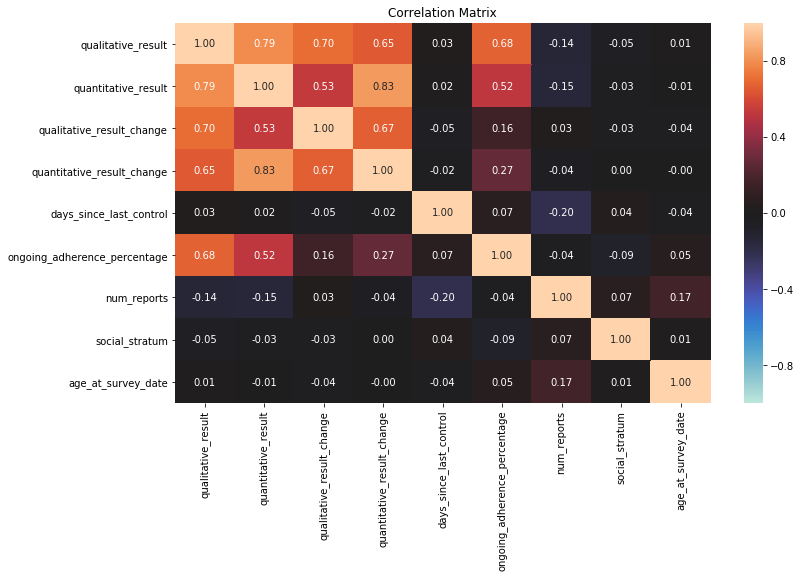

In [71]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_balanced_sample, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

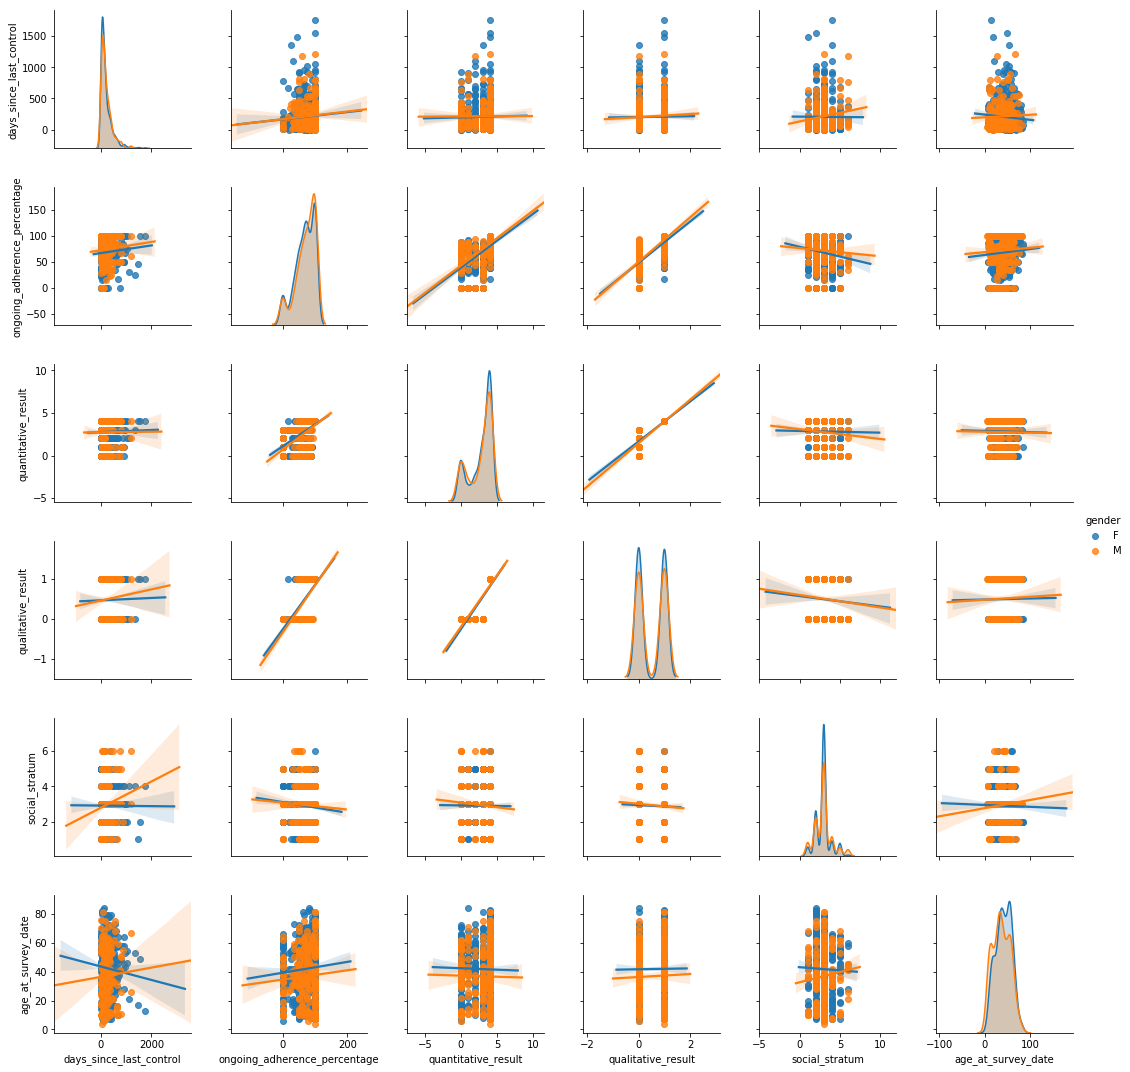

In [72]:
select_vars=['days_since_last_control', 'ongoing_adherence_percentage', 'quantitative_result', 'qualitative_result', 'social_stratum', 'age_at_survey_date']
sns.pairplot(balanced_sample, vars=select_vars, hue='gender', kind='reg')

In [73]:
balanced_sample.dtypes

id_patient                                   int64
survey_date                         datetime64[ns]
category                                  category
qualitative_result                         float64
quantitative_result                        float64
qualitative_result_change                  float64
quantitative_result_change                 float64
days_since_last_control                    float64
ongoing_adherence_percentage               float64
num_reports                                  int64
age                                        float64
gender                                    category
education                                 category
civil_status                              category
department                                  object
city                                        object
social_stratum                             float64
zone                                      category
socioeconomic_level                       category
occupation                     

In [74]:
basic_info_adherence['social_security_regime'].cat.categories

Index(['CONTRIBUTIVO', 'OTRO', 'PARTICULAR', 'SUBSIDIADO'], dtype='object')

# Adherencia vs Escolaridad

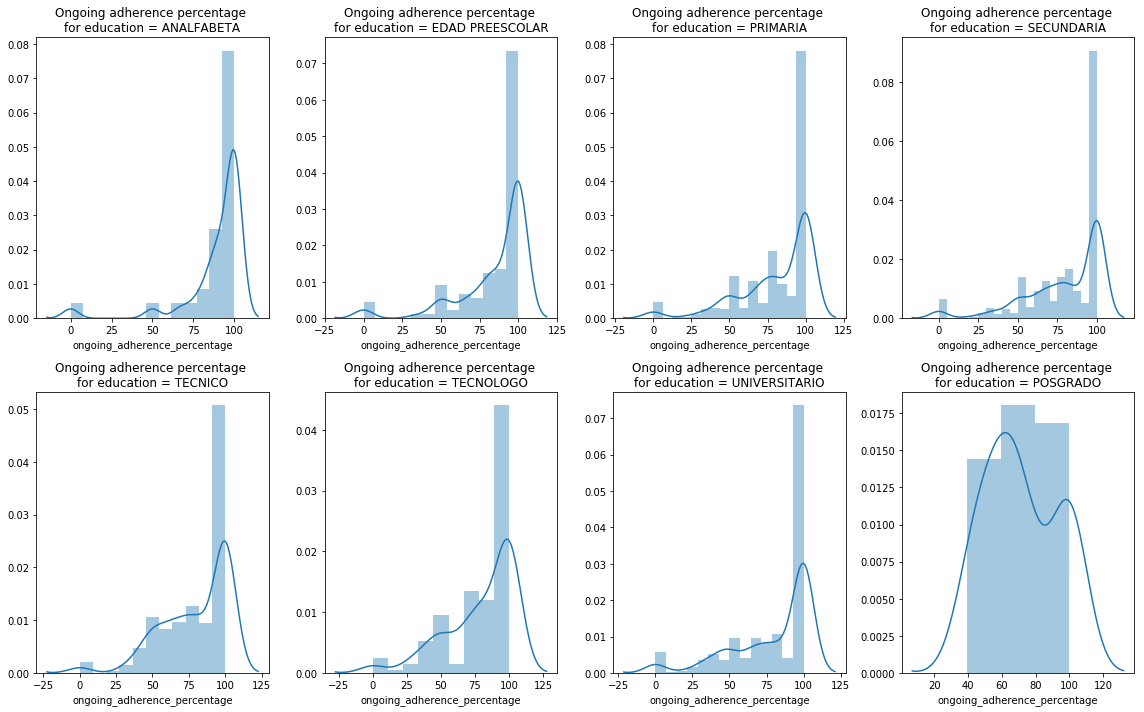

In [75]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['education'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['education'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor education = " + str(level));

plt.tight_layout()

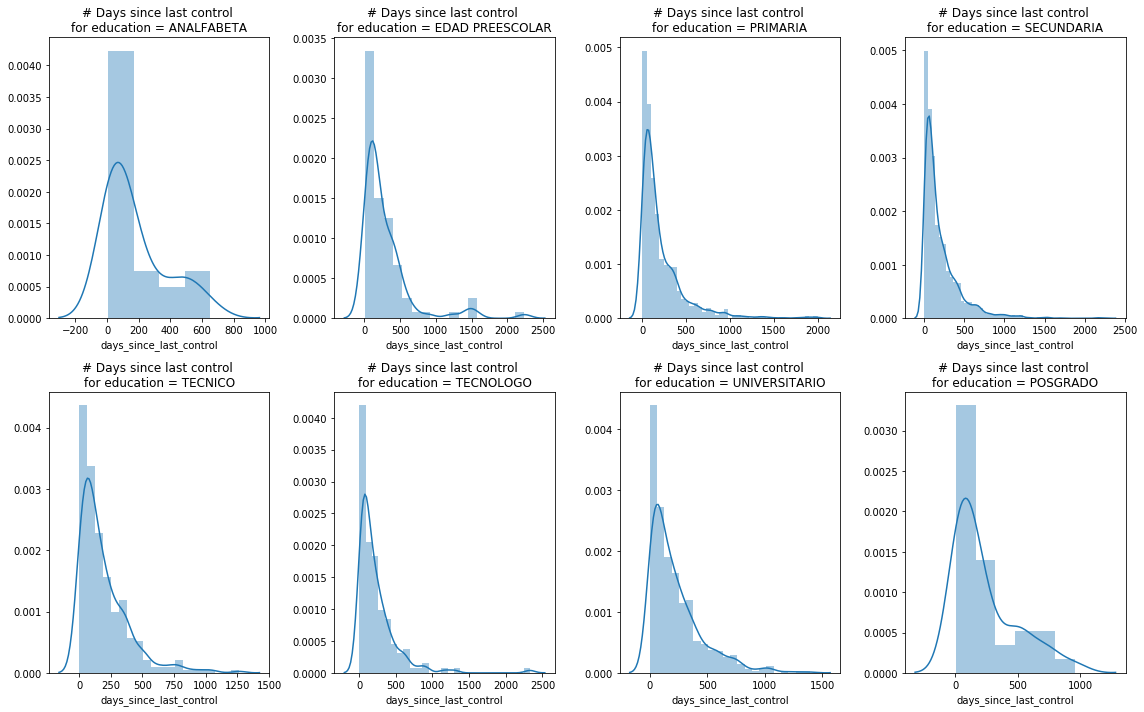

In [76]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['education'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['education'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor education = " + str(level));

plt.tight_layout()

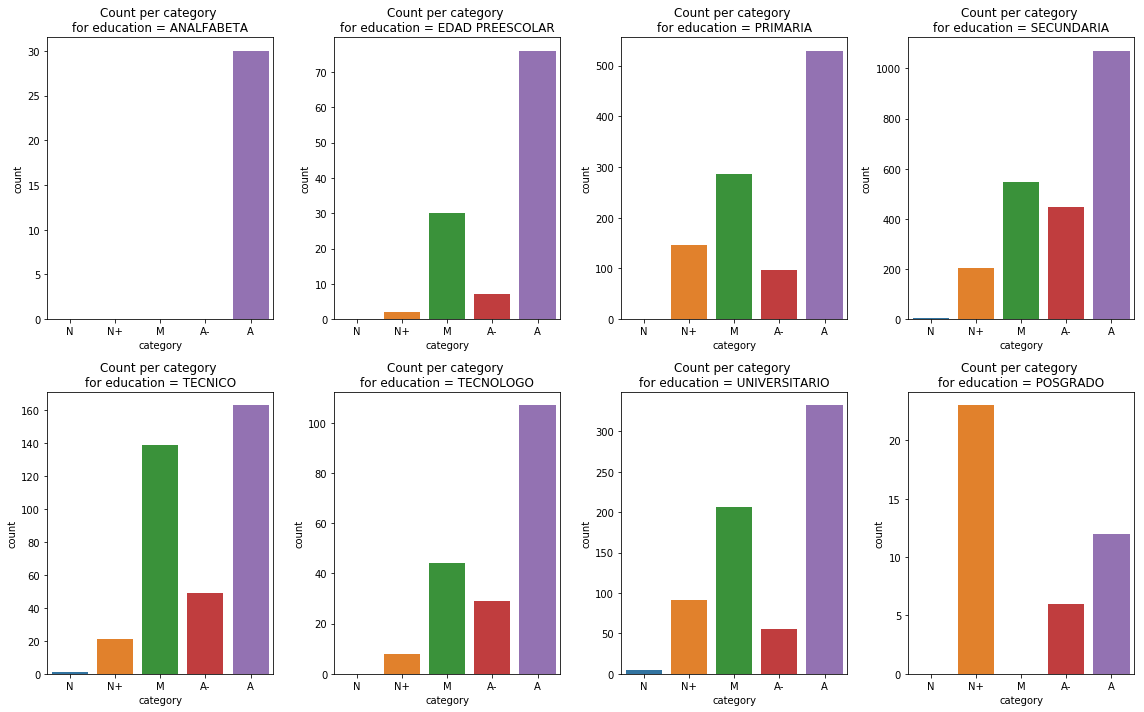

In [77]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['education'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['education'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor education = " + str(level));

plt.tight_layout()

# Adherencia vs Zona (Urbana/Rural)

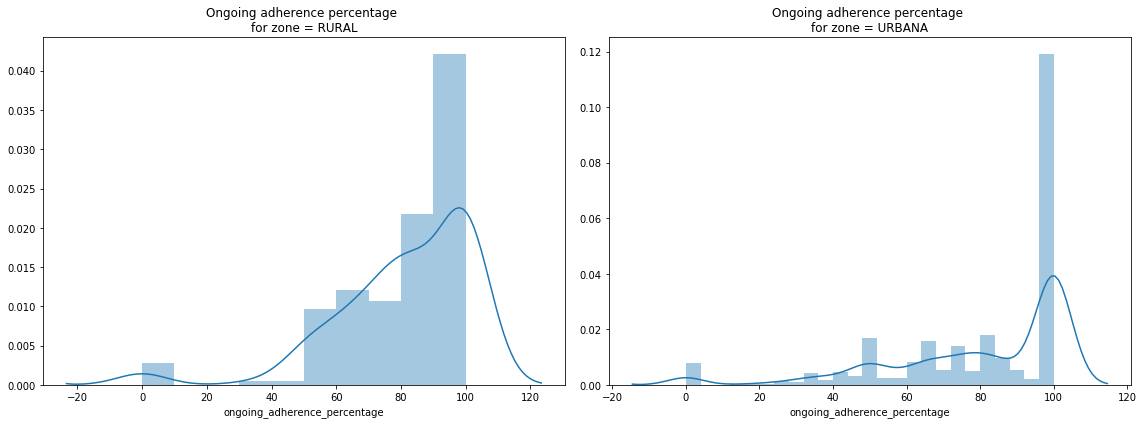

In [78]:
plt.figure(figsize=(16,6))

for i, level in enumerate(basic_info_adherence['zone'].cat.categories):
    plt.subplot(1,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['zone'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor zone = " + str(level));

plt.tight_layout()

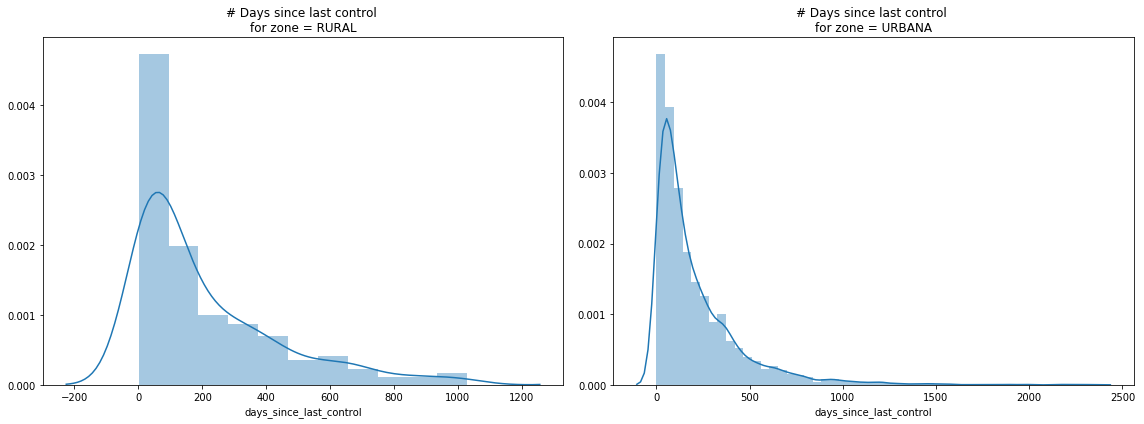

In [79]:
plt.figure(figsize=(16,6))

for i, level in enumerate(basic_info_adherence['zone'].cat.categories):
    plt.subplot(1,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['zone'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor zone = " + str(level));

plt.tight_layout()

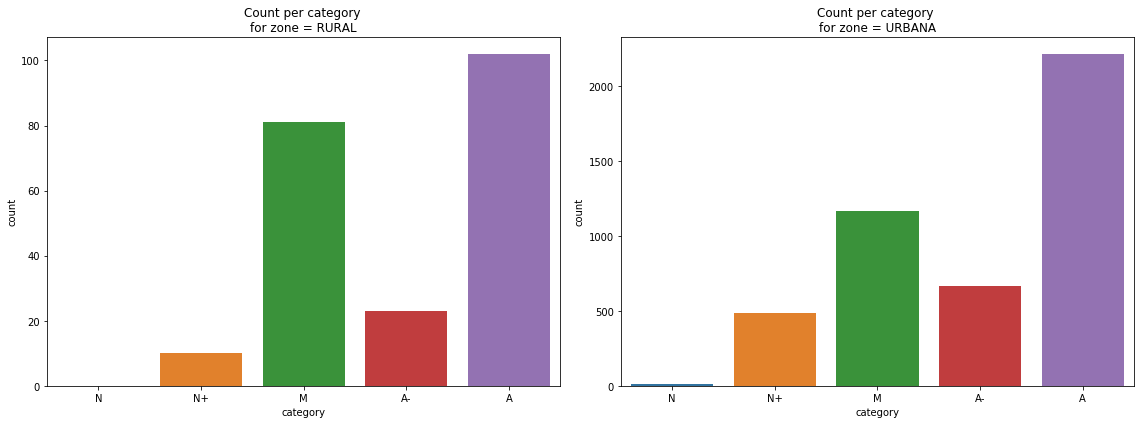

In [80]:
plt.figure(figsize=(16,6))

for i, level in enumerate(basic_info_adherence['zone'].cat.categories):
    plt.subplot(1,2,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['zone'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor zone = " + str(level));

plt.tight_layout()

# Adherencia vs Nivel socioeconomico

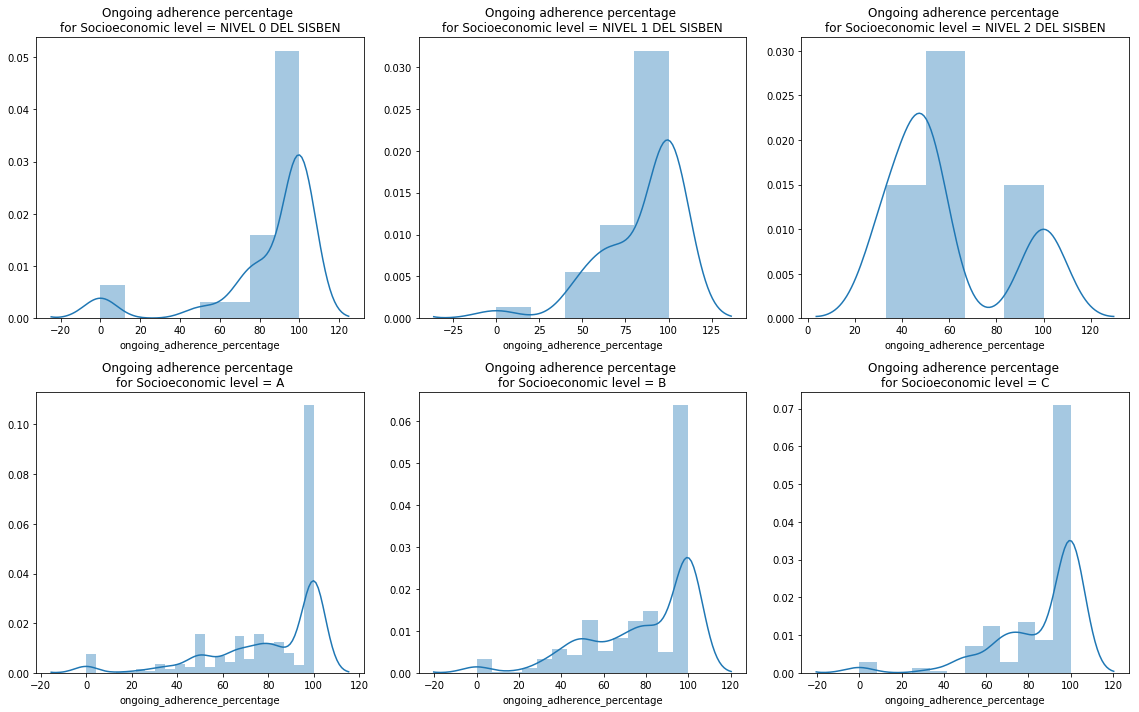

In [81]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['socioeconomic_level'].cat.categories):
    plt.subplot(2,3,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['socioeconomic_level'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor Socioeconomic level = " + str(level));

plt.tight_layout()

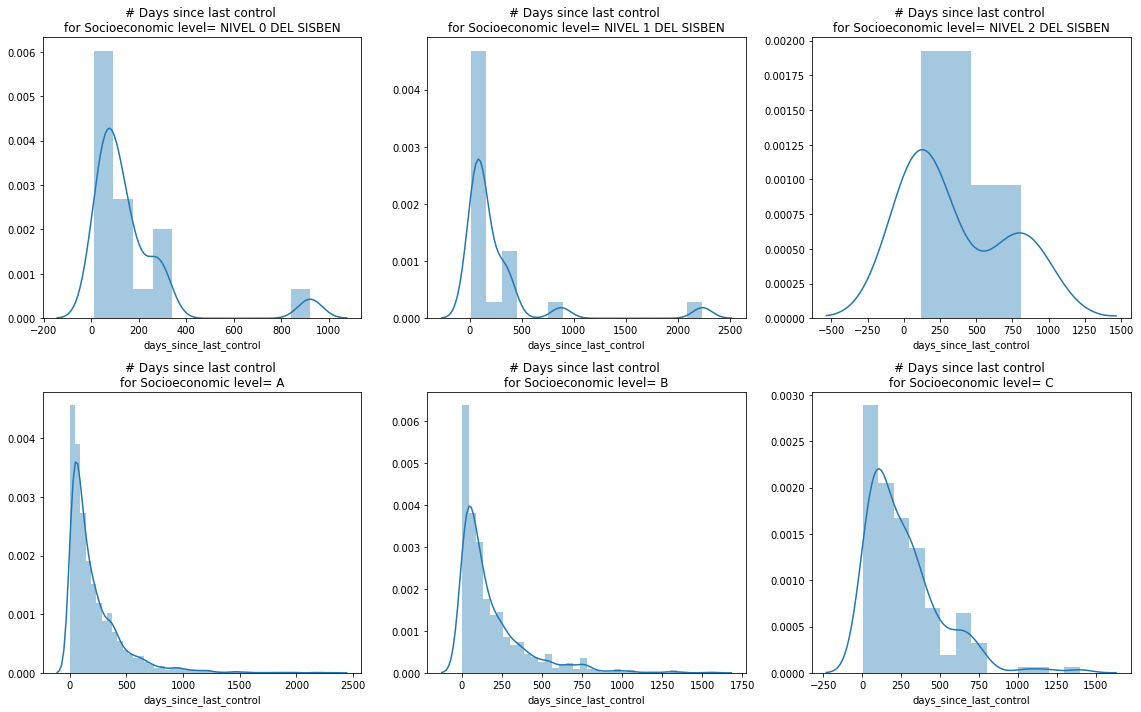

In [82]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['socioeconomic_level'].cat.categories):
    plt.subplot(2,3,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['socioeconomic_level'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor Socioeconomic level= " + str(level));

plt.tight_layout()

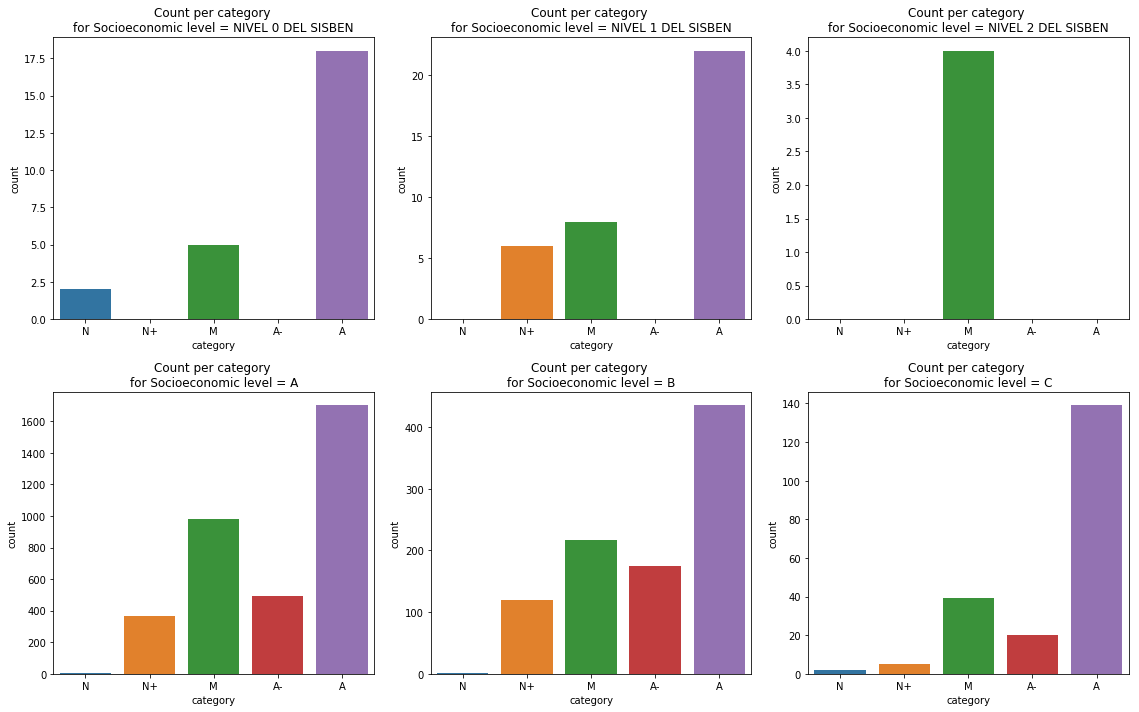

In [83]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['socioeconomic_level'].cat.categories):
    plt.subplot(2,3,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['socioeconomic_level'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor Socioeconomic level = " + str(level));

plt.tight_layout()

# Adherencia vs Ocupacion

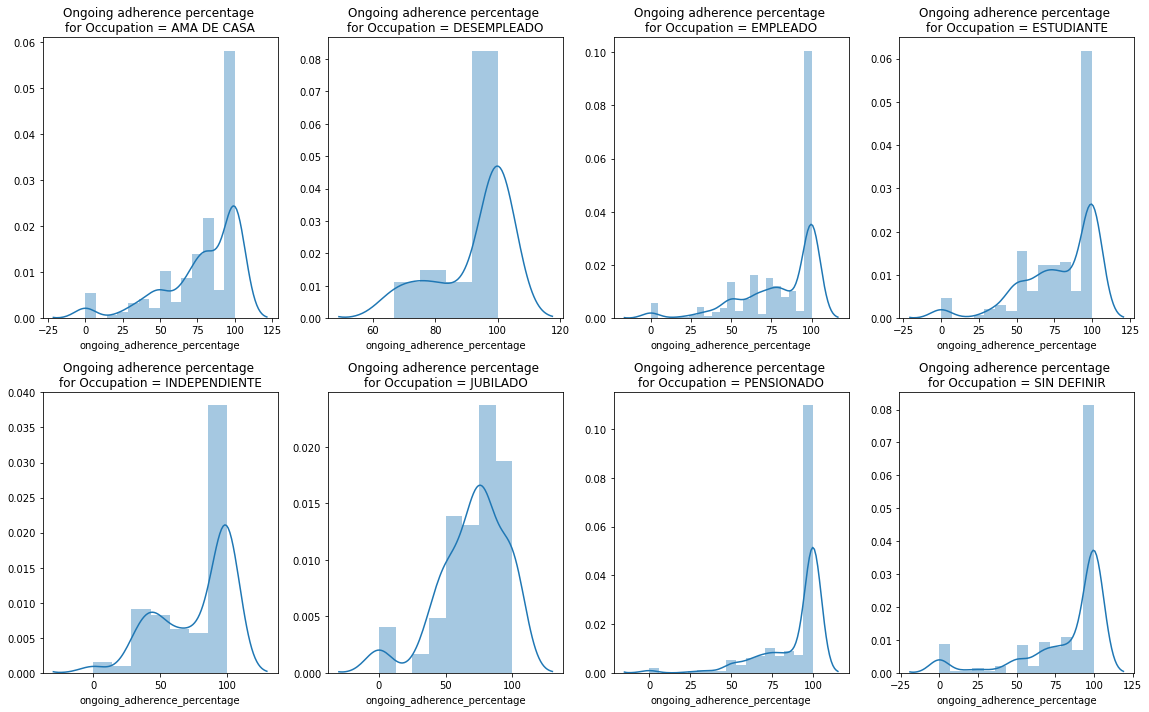

In [84]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['occupation'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['occupation'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor Occupation = " + str(level));

plt.tight_layout()

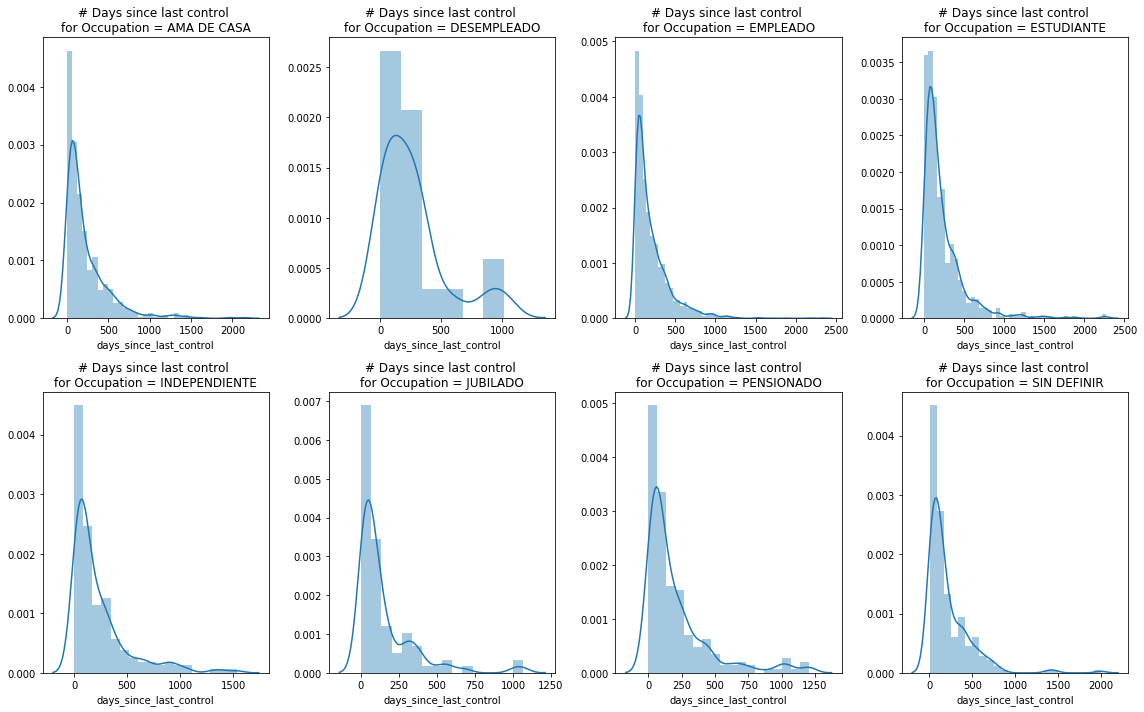

In [85]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['occupation'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['occupation'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor Occupation = " + str(level));

plt.tight_layout()

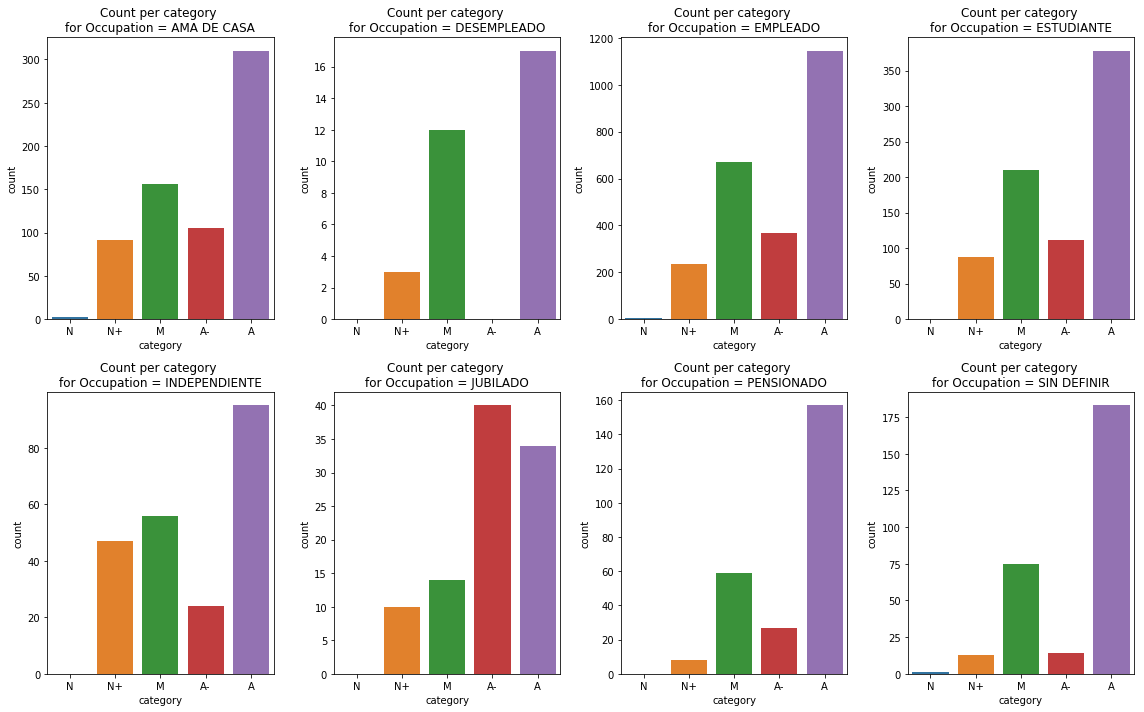

In [86]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['occupation'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['occupation'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor Occupation = " + str(level));

plt.tight_layout()

# Adherencia vs Regimen

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


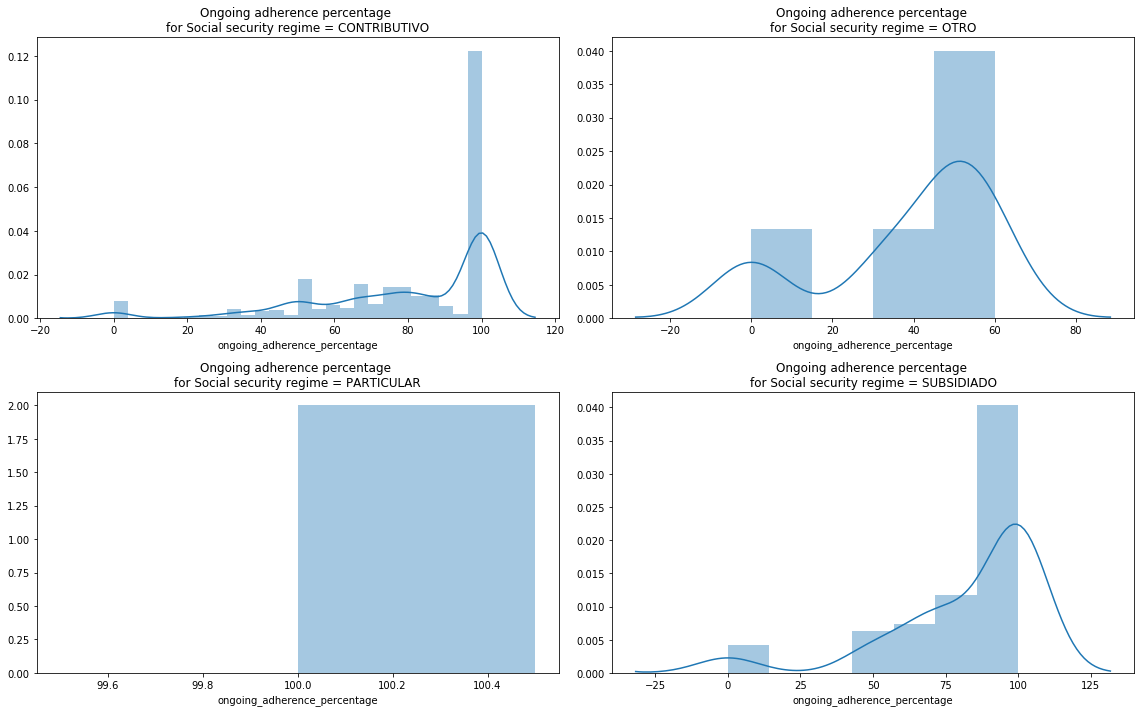

In [87]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['social_security_regime'].cat.categories):
    plt.subplot(2,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['social_security_regime'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor Social security regime = " + str(level));

plt.tight_layout()

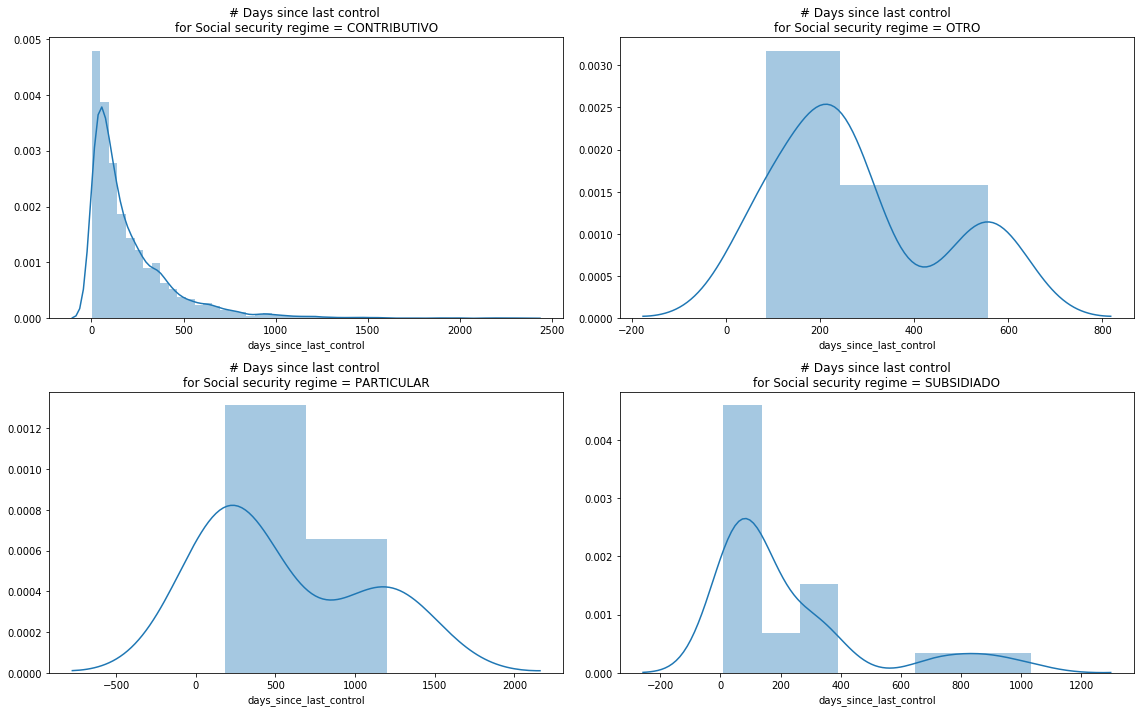

In [88]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['social_security_regime'].cat.categories):
    plt.subplot(2,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['social_security_regime'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor Social security regime = " + str(level));

plt.tight_layout()

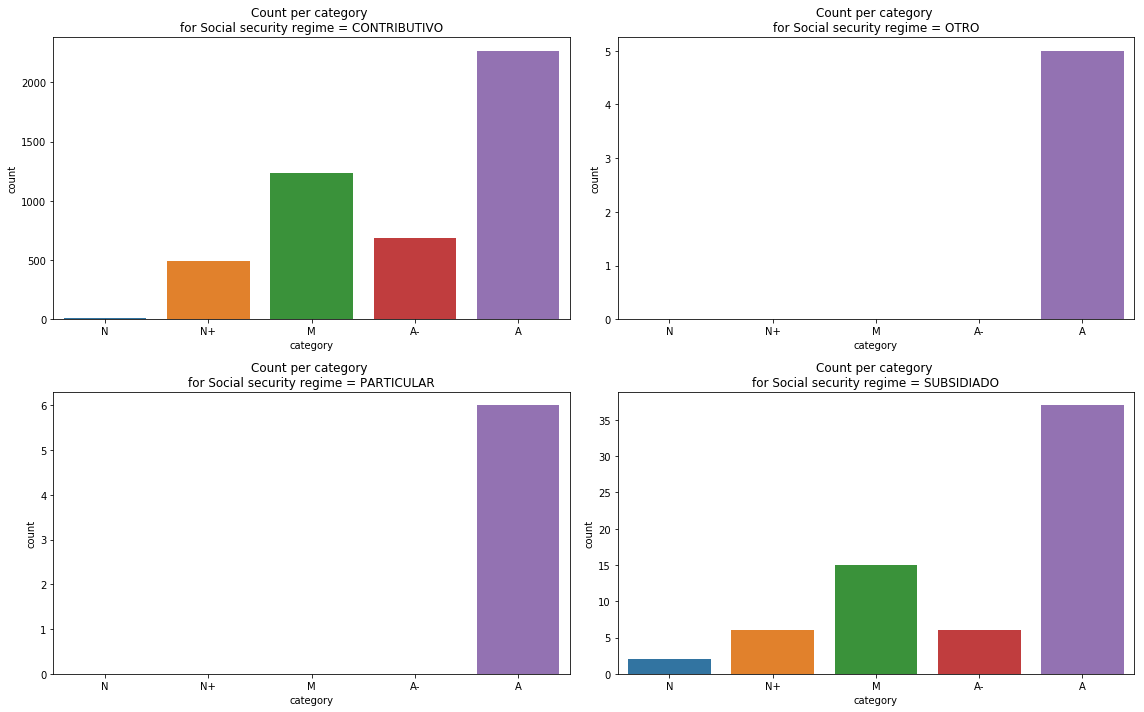

In [89]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['social_security_regime'].cat.categories):
    plt.subplot(2,2,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['social_security_regime'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor Social security regime = " + str(level));

plt.tight_layout()

# Edad entrevista vs Porcentaje historico adherencia

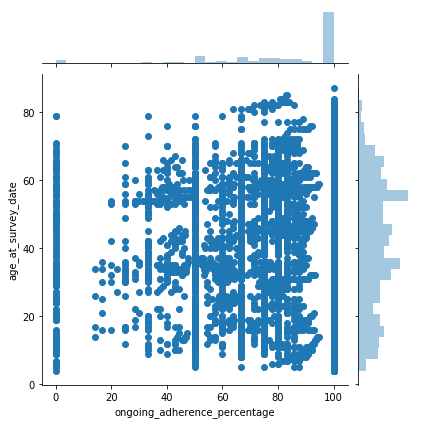

In [90]:
ax = sns.jointplot("ongoing_adherence_percentage", "age_at_survey_date", data=basic_info_adherence)

In [91]:
basic_info_non_adherent_patients.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
8,502989,2014-08-22,M,0.0,2.0,NaN,NaN,NaN,0.000000,1,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
9,502989,2014-10-28,M,0.0,2.0,0.0,0.0,67.0,0.000000,2,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
11,502989,2015-01-07,M,0.0,3.0,0.0,-1.0,47.0,0.000000,4,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
12,502989,2015-01-14,M,0.0,3.0,0.0,0.0,7.0,0.000000,5,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
14,502989,2016-01-12,M,0.0,3.0,-1.0,-1.0,201.0,14.285714,7,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,26
16,502989,2017-01-03,M,0.0,3.0,-1.0,-1.0,354.0,22.222222,9,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,27
36,506808,2019-02-21,M,0.0,0.0,0.0,-4.0,136.0,80.000000,15,...,1.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2008-10-06,2.0,11
48,512938,2019-09-30,M,0.0,1.0,-1.0,-3.0,293.0,72.727273,11,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1997-10-15,3.0,22
62,524006,2017-05-10,A-,0.0,3.0,-1.0,-1.0,28.0,70.000000,10,...,3.0,URBANA,A,PENSIONADO,CONTRIBUTIVO,COTIZANTE,PENSIONADO,1952-08-10,7.0,65
94,529410,2019-02-14,A-,0.0,3.0,0.0,-1.0,380.0,57.142857,7,...,3.0,RURAL,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,1998-01-21,3.0,22


Text(0.5,0,'Social stratum classification')

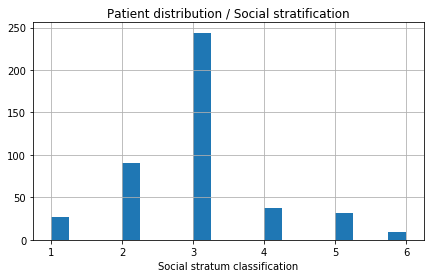

In [92]:
plt.figure(figsize=(7,4))
basic_info_non_adherent_patients['social_stratum'].hist(bins=20)
plt.title("Patient distribution / Social stratification")
plt.xlabel("Social stratum classification")

In [93]:
count_per_depto = basic_info_non_adherent_patients[['id_patient', 'department']].groupby('department').count().reset_index()
count_per_depto.columns = ['department', 'count_patients']
count_per_depto['percentage'] = (count_per_depto['count_patients'] / sum(count_per_depto['count_patients']))*100
count_per_depto.sort_values(by='count_patients', ascending=False).set_index('department')

,count_patients,percentage
department,,
ANTIOQUIA,406,92.272727
ATLANTICO,13,2.954545
VALLE DEL CAUCA,9,2.045455
SANTAFE DE BOGOTA D.C,6,1.363636
CALDAS,4,0.909091
CUNDINAMARCA,2,0.454545


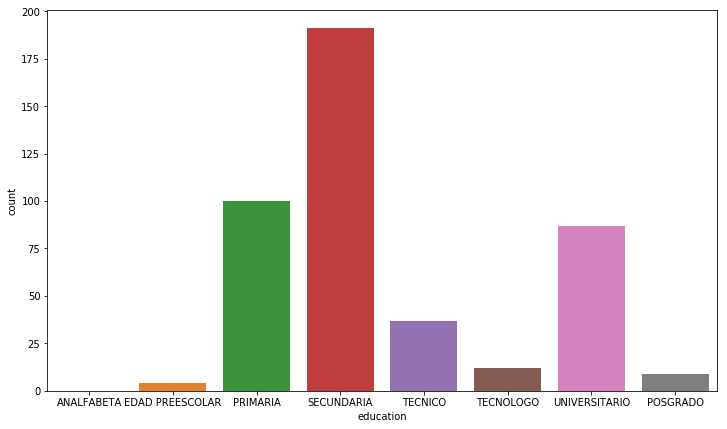

In [94]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('education').size().reset_index(name='count'), x='education', y='count', ax=ax)

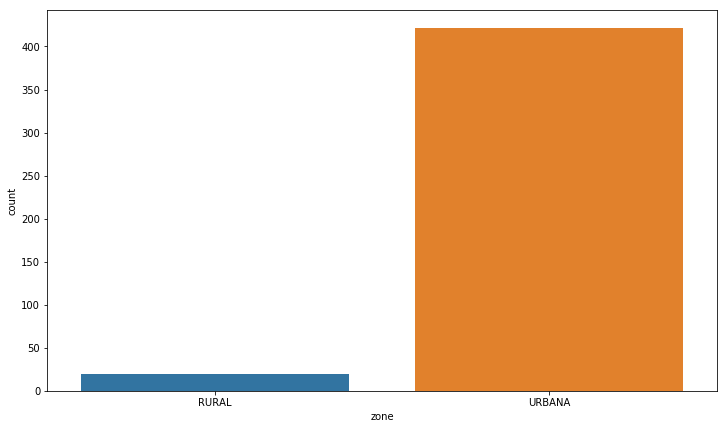

In [95]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('zone').size().reset_index(name='count'), x='zone', y='count', ax=ax)

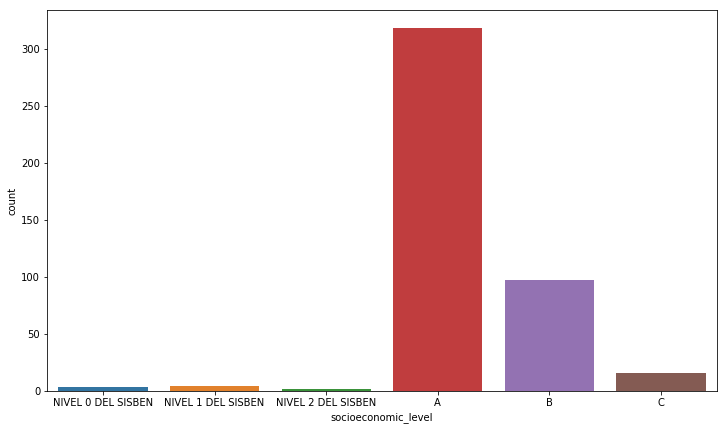

In [96]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('socioeconomic_level').size().reset_index(name='count'), x='socioeconomic_level', y='count', ax=ax)

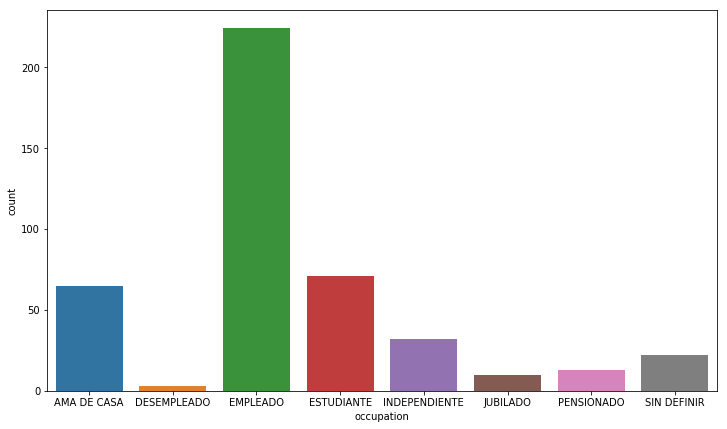

In [97]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('occupation').size().reset_index(name='count'), x='occupation', y='count', ax=ax)

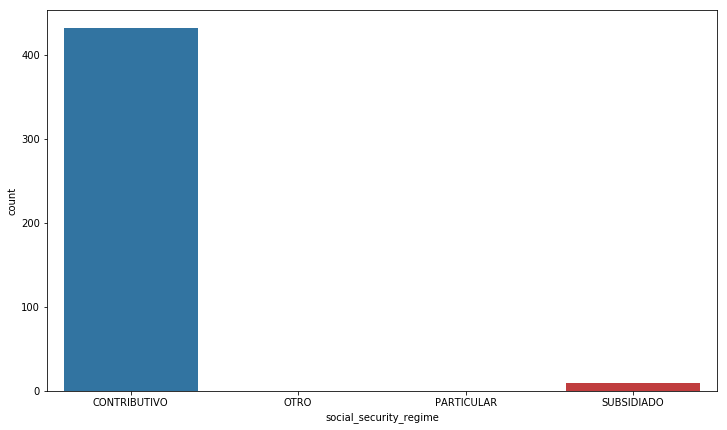

In [98]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('social_security_regime').size().reset_index(name='count'), x='social_security_regime', y='count', ax=ax)

Text(0.5,0,'Age')

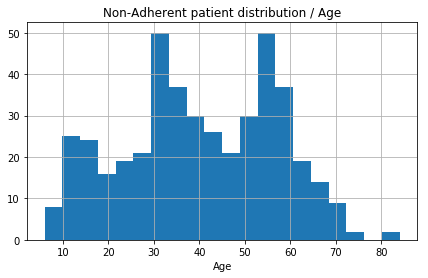

In [99]:
plt.figure(figsize=(7,4))
basic_info_non_adherent_patients['age_at_survey_date'].hist(bins=20)
plt.title("Non-Adherent patient distribution / Age")
plt.xlabel("Age")

# Frequency analysis

In [100]:
corr_adherence = adherence_change_analysis.corr()

Text(0.5,1,'Correlation Matrix')

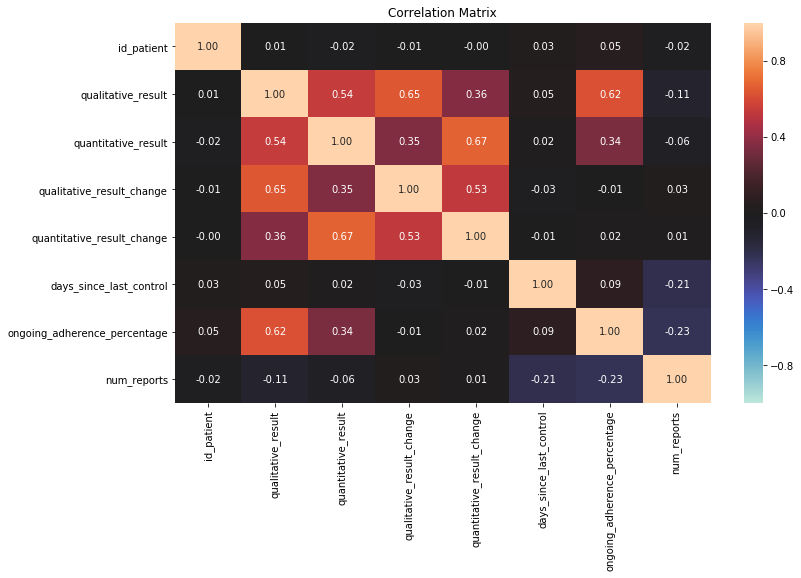

In [102]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_adherence, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

How often a patient goes from non-adherent to adherent:

$P_{AdherentTransition} = \frac{\|PositiveTransitions\|}{\|PositiveTransitions\| + \|NoTransition|_{NonAdherent}\|}$

$P_{StayNonAdherent} = 1-P_{AdherentTransition}$

$P_{NonAdherentTransition} = \frac{\|NegativeTransitions\|}{\|NegativeTransitions\| + \|NoTransition|_{Adherent}\|}$

$P_{StayAdherent} = 1-P_{NonAdherentTransition}$

$P_{Transition} = \frac{\|PositiveTransitions\|+\|NegativeTransitions\|}{\|PositiveTransitions\| + \|NoTransition|_{NonAdherent}\| + \|NegativeTransitions\| + \|NoTransition|_{Adherent}\|}$

$P_{StayUnchanged} = 1-P_{Transition}$

In [103]:
num_pos_transitions = len(pos_transition)
num_neg_transitions = len(neg_transition)
num_no_trans_no_adherent = len(adherence_change_analysis[(adherence_change_analysis['qualitative_result'] == 0) & (adherence_change_analysis['qualitative_result_change'] == 0)])
num_no_trans_adherent = len(adherence_change_analysis[(adherence_change_analysis['qualitative_result'] == 1) & (adherence_change_analysis['qualitative_result_change'] == 0)])

In [104]:
pat_full_data = num_pos_transitions / (num_pos_transitions + num_no_trans_no_adherent)
print(f'Probability of a patient going from Non-adherent to Adherent: {round(pat_full_data, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat_full_data, 2)}')

Probability of a patient going from Non-adherent to Adherent: 0.65
Probability of a patient staying non-adherent: 0.35


In [105]:
pnt_full_data = num_neg_transitions / (num_neg_transitions + num_no_trans_adherent)
print(f'Probability of a patient going from Adherent to Non-adherent: {round(pnt_full_data, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt_full_data, 2)}')

Probability of a patient going from Adherent to Non-adherent: 0.19
Probability of a patient staying Adherent: 0.81


In [106]:
pt_full_data = (num_pos_transitions + num_neg_transitions) / (num_neg_transitions + num_no_trans_adherent + num_pos_transitions + num_no_trans_no_adherent)
print(f'Probability of a patient transitioning (NA -> A or A -> NA): {round(pt_full_data, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt_full_data, 2)}')

Probability of a patient transitioning (NA -> A or A -> NA): 0.29
Probability of a patient remaining unchaged: 0.71


## Analysis according to demographic variables:

In [107]:
vbles = ['gender', 'education', 'zone', 'socioeconomic_level', 'occupation', 'employment_type']

def estimate_probabilities4variable(df, variable):
    print('***********************************************************************')
    print(f'Probabilities for vble={variable}')
    print('---------------------------------')
    for val in df[variable].cat.categories:
        print(f'{variable}={val}:')
        num_pos_transitions = len(df[(df[variable]==val) & (df['qualitative_result_change']==1)])
        num_neg_transitions = len(df[(df[variable]==val) & (df['qualitative_result_change']==-1)])
        num_no_trans_no_adherent = len(df[(df[variable]==val) & (df['qualitative_result'] == 0) & (df['qualitative_result_change'] == 0)])
        num_no_trans_adherent = len(df[(df[variable]==val) & (df['qualitative_result'] == 1) & (df['qualitative_result_change'] == 0)])
        pat_full_data = num_pos_transitions / (num_pos_transitions + num_no_trans_no_adherent)
        print(f'Probability of a patient going from Non-adherent to Adherent: {round(pat_full_data, 2)}')
        print(f'Probability of a patient staying non-adherent: {round(1-pat_full_data, 2)}')
        print('-----------------------------------------------------------------------')
        pnt_full_data = num_neg_transitions / (num_neg_transitions + num_no_trans_adherent)
        print(f'Probability of a patient going from Adherent to Non-adherent: {round(pnt_full_data, 2)}')
        print(f'Probability of a patient staying Adherent: {round(1-pnt_full_data, 2)}')
        print('-----------------------------------------------------------------------')
        pt_full_data = (num_pos_transitions + num_neg_transitions) / (num_neg_transitions + num_no_trans_adherent + num_pos_transitions + num_no_trans_no_adherent)
        print(f'Probability of a patient transitioning (NA -> A or A -> NA): {round(pt_full_data, 2)}')
        print(f'Probability of a patient remaining unchaged: {round(1-pt_full_data, 2)}')
        print('-----------------------------------------------------------------------')
        
for vble in vbles:
    estimate_probabilities4variable(basic_info_adherence, vble)

***********************************************************************
Probabilities for vble=gender
---------------------------------
gender=F:
Probability of a patient going from Non-adherent to Adherent: 0.65
Probability of a patient staying non-adherent: 0.35
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.19
Probability of a patient staying Adherent: 0.81
-----------------------------------------------------------------------
Probability of a patient transitioning (NA -> A or A -> NA): 0.29
Probability of a patient remaining unchaged: 0.71
-----------------------------------------------------------------------
gender=M:
Probability of a patient going from Non-adherent to Adherent: 0.66
Probability of a patient staying non-adherent: 0.34
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.18
Probability of a pat

Probability of a patient going from Non-adherent to Adherent: 1.0
Probability of a patient staying non-adherent: 0.0
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.22
Probability of a patient staying Adherent: 0.78
-----------------------------------------------------------------------
Probability of a patient transitioning (NA -> A or A -> NA): 0.39
Probability of a patient remaining unchaged: 0.61
-----------------------------------------------------------------------
socioeconomic_level=NIVEL 2 DEL SISBEN:
Probability of a patient going from Non-adherent to Adherent: 0.5
Probability of a patient staying non-adherent: 0.5
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 1.0
Probability of a patient staying Adherent: 0.0
-----------------------------------------------------------------------
Probability of a patie

Probability of a patient going from Non-adherent to Adherent: 0.66
Probability of a patient staying non-adherent: 0.34
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.2
Probability of a patient staying Adherent: 0.8
-----------------------------------------------------------------------
Probability of a patient transitioning (NA -> A or A -> NA): 0.31
Probability of a patient remaining unchaged: 0.69
-----------------------------------------------------------------------
employment_type=PENSIONADO:
Probability of a patient going from Non-adherent to Adherent: 0.6
Probability of a patient staying non-adherent: 0.4
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.11
Probability of a patient staying Adherent: 0.89
-----------------------------------------------------------------------
Probability of a patient transit

In [108]:
basic_info_adherence.dtypes

id_patient                                   int64
survey_date                         datetime64[ns]
category                                  category
qualitative_result                         float64
quantitative_result                        float64
qualitative_result_change                  float64
quantitative_result_change                 float64
days_since_last_control                    float64
ongoing_adherence_percentage               float64
num_reports                                  int64
age                                        float64
gender                                    category
education                                 category
civil_status                              category
department                                  object
city                                        object
social_stratum                             float64
zone                                      category
socioeconomic_level                       category
occupation                     

### AGE